# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

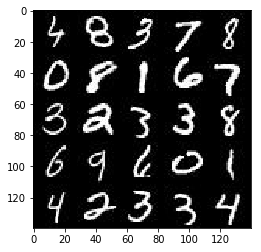

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

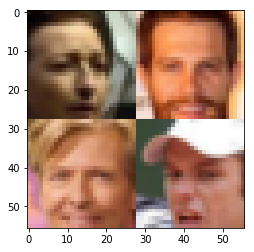

In [3]:
show_n_images = 4

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


/home/i11/angriman/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    realInputImages = tf.placeholder(
        dtype=tf.float32,
        shape=(None, image_width, image_height, image_channels),
        name='real_inputs'
    )
    
    zData = tf.placeholder(
        dtype=tf.float32,
        shape=(None, z_dim),
        name='z_inputs'
    )
    
    learningRate = tf.placeholder(tf.float32, name='learning_rate')
    
    return realInputImages, zData, learningRate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/i11/angriman/miniconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/i11/angriman/miniconda3/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/i11/angriman/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/i11/angriman/miniconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/i11/angriman/miniconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/i11/angriman/miniconda3/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    # Size of input image (for CelebA: (28, 28))
    input_size = images.shape[1:3]
    
    # Parameters for convolutional layers
    kernel_size = 5
    strides = 2
    padding = 'SAME'
    
    # Parameter for the leaky relu
    alpha = 0.2
    
    # Defining the leaky relu function
    def leakyRelu(input_tensor, alpha):
        return tf.maximum(input_tensor * alpha, input_tensor)
    
    
    # Building a three-layered discriminator network
    with tf.variable_scope("discriminator", reuse=reuse):
        
        # At each layer we double the image depth. 
        filters = 128
        
        ### First layer (without batch normalization) ###
        
        # The size of the input image is 28x28x3
        x = tf.layers.conv2d(
            inputs=images,
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding
        )
        x = leakyRelu(x, alpha)
        # Output: 14x14x128
        
        filters *= 2
        
        ### Second layer ###
        x = tf.layers.conv2d(
            inputs=x,
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding
        )
        x = tf.layers.batch_normalization(x, training=True)
        x = leakyRelu(x, alpha)
        # Output: 7x7x256
        
        filters *= 2
        
        ### Third layer ###
        x = tf.layers.conv2d(
            inputs=x,
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding
        )
        x = tf.layers.batch_normalization(x, training=True)
        x = leakyRelu(x, alpha)
        # Output: 4x4x512
        
        flat = tf.reshape(x, (-1, 4*4*filters))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    reuse = not is_train
    
    # Leaky relu parameter
    alpha = 0.2
    
    # Parameters for convolutions
    kernel_size = 5
    strides = 2
    padding = 'SAME'
    keep_prob = 0.35
    
    # Leaky relu function
    def leakyRelu(input_tensor, alpha):
        return tf.maximum(input_tensor * alpha, input_tensor)
    
    # Using a five-layered convolutional network
    with tf.variable_scope('generator', reuse=reuse):
        
        filters = 1024

        # Fully connected layer
        x = tf.layers.dense(z, 2*2*filters)
        
        # Reshape for the convolution stack
        x = tf.reshape(x, (-1, 2, 2, filters))
        
        x = tf.layers.batch_normalization(x, training=is_train)
        x = leakyRelu(x, alpha)
        
        filters = int(filters/2)
        
        ### First layer (input: 2x2x1024) ###
        x = tf.layers.conv2d_transpose(
            inputs=x,
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            kernel_initializer=tf.contrib.layers.xavier_initializer()
        )
        x = tf.layers.batch_normalization(x, training=is_train)
        x = leakyRelu(x, alpha)
        #x = tf.contrib.layers.dropout(x, keep_prob, is_training=is_train)
        # Output: 4x4x512

        filters = int(filters/2)
        
        ### Second layer ###
        x = tf.layers.conv2d_transpose(
            inputs=x,
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            kernel_initializer=tf.contrib.layers.xavier_initializer()
        )
        x = tf.layers.batch_normalization(x, training=is_train)
        x = leakyRelu(x, alpha)
        #x = tf.contrib.layers.dropout(x, keep_prob, is_training=is_train)
        # Output: 8x8x256
                    
        filters = int(filters/2)
        
        ### Third layer ###
        x = tf.layers.conv2d_transpose(
            inputs=x,
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            kernel_initializer=tf.contrib.layers.xavier_initializer()
        )
        x = tf.layers.batch_normalization(x, training=is_train)
        x = leakyRelu(x, alpha)
        #x = tf.contrib.layers.dropout(x, keep_prob, is_training=is_train)
        # Output: 16x16x128
        
        filters = int(filters/2)
        
        ### Fourth layer ###
        x = tf.layers.conv2d_transpose(
            inputs=x,
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            kernel_initializer=tf.contrib.layers.xavier_initializer()
        )
        x = tf.layers.batch_normalization(x, training=is_train)
        x = leakyRelu(x, alpha)
        #x = tf.contrib.layers.dropout(x, keep_prob, is_training=is_train)
        # Output: 32x32x64
        
        
        ### Fifth layer ###
        logits = tf.layers.conv2d_transpose(
            inputs=x,
            filters=out_channel_dim,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            kernel_initializer=tf.contrib.layers.xavier_initializer()
        )
        # Output: 64x64x(out_channel_dim)
        
        #logits = tf.contrib.layers.dropout(logits, keep_prob, is_training=is_train)
        
        logits = tf.image.resize_images(logits, (28, 28))
        out = tf.tanh(logits)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    gen = generator(input_z, out_channel_dim)
    dis_real, dis_logits_real = discriminator(input_real)
    dis_fake, dis_logits_fake = discriminator(gen, reuse=True)
    
    # Discriminator loss for real images
    dis_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=dis_logits_real,
            labels=tf.ones_like(dis_real)
        )
    )
    
    # Discriminator loss for fake images
    dis_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=dis_logits_fake,
            labels=tf.zeros_like(dis_fake)
        )
    )
    
    # The discriminator loss is the summ of the two losses
    dis_loss = dis_loss_real + dis_loss_fake
    
    # Generator loss
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=dis_logits_fake,
            labels=tf.ones_like(dis_fake)
        )
    )
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        opt_d = tf.train.AdamOptimizer(
            learning_rate=learning_rate,
            beta1=beta1
        ).minimize(d_loss, var_list=d_vars)
        
        opt_g = tf.train.AdamOptimizer(
            learning_rate=learning_rate,
            beta1=beta1
        ).minimize(g_loss, var_list=g_vars)
        
    return opt_d, opt_g


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    n_samples, image_width, image_height, image_channels = data_shape

    input_real, input_z, l_r = model_inputs(
        image_width=image_width,
        image_height=image_height,
        image_channels=image_channels,
        z_dim=z_dim
    )
    
    d_loss, g_loss = model_loss(
        input_real=input_real,
        input_z=input_z,
        out_channel_dim=data_shape[3]
    )
    
    d_opt, g_opt = model_opt(
        d_loss=d_loss,
        g_loss=g_loss,
        learning_rate=l_r,
        beta1=beta1
    )
    
    step = 0
    print_every = 10
    show_generator_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                step += 1
                
                batch_images *= 2

                # Generating random noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(
                    d_opt,
                    feed_dict={
                        input_real: batch_images,
                        input_z: batch_z,
                        l_r: learning_rate
                    }
                )
                
                _ = sess.run(
                    g_opt,
                    feed_dict={
                        input_real: batch_images,
                        input_z: batch_z,
                        l_r: learning_rate
                    }
                )
                
                if step % print_every == 0:
                    # Getting losses at this point of the training and printing them
                    train_loss_d = d_loss.eval({
                        input_real: batch_images,
                        input_z: batch_z
                    })
                    train_loss_g = g_loss.eval({
                        input_real: batch_images,
                        input_z: batch_z
                    })
                    
                    print("Epoch {}/{} --- ".format(epoch_i+1, epoch_count),
                          "Discriminator loss: {:.4f}".format(train_loss_d),
                          "Generator loss: {:.4f}".format(train_loss_g))
                
                if step % show_generator_every == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 ---  Discriminator loss: 0.4534 Generator loss: 20.5204
Epoch 1/2 ---  Discriminator loss: 0.9432 Generator loss: 0.5557
Epoch 1/2 ---  Discriminator loss: 3.6726 Generator loss: 14.2511
Epoch 1/2 ---  Discriminator loss: 1.8301 Generator loss: 4.7942
Epoch 1/2 ---  Discriminator loss: 1.6914 Generator loss: 6.6517
Epoch 1/2 ---  Discriminator loss: 1.8232 Generator loss: 0.2212
Epoch 1/2 ---  Discriminator loss: 0.2657 Generator loss: 4.7964
Epoch 1/2 ---  Discriminator loss: 1.6639 Generator loss: 0.2398
Epoch 1/2 ---  Discriminator loss: 2.0743 Generator loss: 9.4329
Epoch 1/2 ---  Discriminator loss: 0.7796 Generator loss: 0.8344


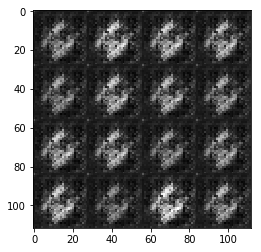

Epoch 1/2 ---  Discriminator loss: 0.3036 Generator loss: 3.2970
Epoch 1/2 ---  Discriminator loss: 0.6634 Generator loss: 1.2273
Epoch 1/2 ---  Discriminator loss: 0.8439 Generator loss: 0.9126
Epoch 1/2 ---  Discriminator loss: 1.3913 Generator loss: 0.4954
Epoch 1/2 ---  Discriminator loss: 1.7483 Generator loss: 0.2538
Epoch 1/2 ---  Discriminator loss: 1.3265 Generator loss: 8.2746
Epoch 1/2 ---  Discriminator loss: 1.6634 Generator loss: 0.4379
Epoch 1/2 ---  Discriminator loss: 0.3789 Generator loss: 1.5785
Epoch 1/2 ---  Discriminator loss: 1.0659 Generator loss: 0.5326
Epoch 1/2 ---  Discriminator loss: 1.9792 Generator loss: 0.2350


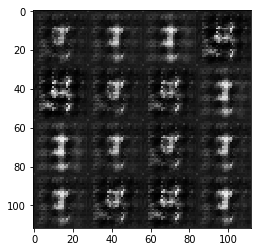

Epoch 1/2 ---  Discriminator loss: 3.0947 Generator loss: 0.0601
Epoch 1/2 ---  Discriminator loss: 0.8532 Generator loss: 2.0448
Epoch 1/2 ---  Discriminator loss: 0.5113 Generator loss: 1.3605
Epoch 1/2 ---  Discriminator loss: 0.7623 Generator loss: 0.8203
Epoch 1/2 ---  Discriminator loss: 1.7145 Generator loss: 0.2645
Epoch 1/2 ---  Discriminator loss: 1.2736 Generator loss: 0.4885
Epoch 1/2 ---  Discriminator loss: 0.9933 Generator loss: 0.6386
Epoch 1/2 ---  Discriminator loss: 1.2107 Generator loss: 0.4963
Epoch 1/2 ---  Discriminator loss: 0.7791 Generator loss: 3.6507
Epoch 1/2 ---  Discriminator loss: 1.0526 Generator loss: 5.8260


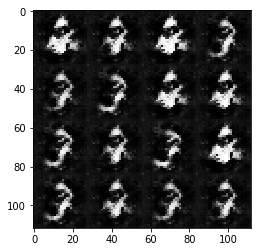

Epoch 1/2 ---  Discriminator loss: 2.0679 Generator loss: 0.1694
Epoch 1/2 ---  Discriminator loss: 1.0033 Generator loss: 0.8211
Epoch 1/2 ---  Discriminator loss: 1.5995 Generator loss: 0.3423
Epoch 1/2 ---  Discriminator loss: 0.6759 Generator loss: 1.0921
Epoch 1/2 ---  Discriminator loss: 0.5512 Generator loss: 1.5204
Epoch 1/2 ---  Discriminator loss: 0.6213 Generator loss: 2.3398
Epoch 1/2 ---  Discriminator loss: 0.6130 Generator loss: 3.2527
Epoch 1/2 ---  Discriminator loss: 0.8425 Generator loss: 0.7729
Epoch 1/2 ---  Discriminator loss: 0.4268 Generator loss: 1.2454
Epoch 1/2 ---  Discriminator loss: 0.9211 Generator loss: 0.6576


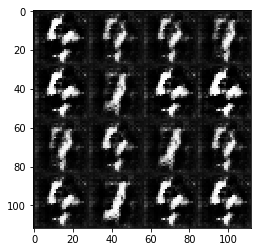

Epoch 1/2 ---  Discriminator loss: 1.2859 Generator loss: 0.4559
Epoch 1/2 ---  Discriminator loss: 0.7204 Generator loss: 1.4685
Epoch 1/2 ---  Discriminator loss: 1.3844 Generator loss: 5.8244
Epoch 1/2 ---  Discriminator loss: 0.5676 Generator loss: 1.2564
Epoch 1/2 ---  Discriminator loss: 0.8327 Generator loss: 2.8052
Epoch 1/2 ---  Discriminator loss: 1.7128 Generator loss: 0.3661
Epoch 1/2 ---  Discriminator loss: 0.7537 Generator loss: 1.0283
Epoch 1/2 ---  Discriminator loss: 0.4335 Generator loss: 1.6916
Epoch 1/2 ---  Discriminator loss: 0.4178 Generator loss: 2.0521
Epoch 1/2 ---  Discriminator loss: 0.7979 Generator loss: 5.0790


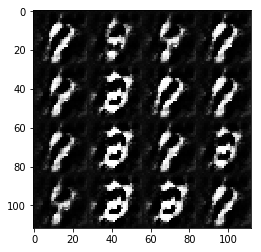

Epoch 1/2 ---  Discriminator loss: 0.6997 Generator loss: 1.0991
Epoch 1/2 ---  Discriminator loss: 0.3756 Generator loss: 1.5272
Epoch 1/2 ---  Discriminator loss: 0.4190 Generator loss: 1.4725
Epoch 1/2 ---  Discriminator loss: 2.2084 Generator loss: 0.1550
Epoch 1/2 ---  Discriminator loss: 0.3671 Generator loss: 2.0097
Epoch 1/2 ---  Discriminator loss: 0.5504 Generator loss: 1.0141
Epoch 1/2 ---  Discriminator loss: 0.7710 Generator loss: 3.5560
Epoch 1/2 ---  Discriminator loss: 0.7502 Generator loss: 4.9634
Epoch 1/2 ---  Discriminator loss: 0.4083 Generator loss: 2.0677
Epoch 1/2 ---  Discriminator loss: 0.5270 Generator loss: 1.1400


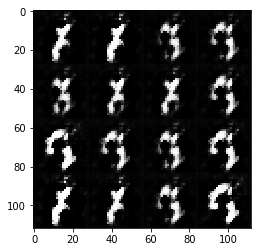

Epoch 1/2 ---  Discriminator loss: 0.4874 Generator loss: 1.1525
Epoch 1/2 ---  Discriminator loss: 0.6376 Generator loss: 2.6537
Epoch 1/2 ---  Discriminator loss: 0.7282 Generator loss: 4.8407
Epoch 1/2 ---  Discriminator loss: 0.4301 Generator loss: 1.8849
Epoch 1/2 ---  Discriminator loss: 0.7209 Generator loss: 5.8783
Epoch 1/2 ---  Discriminator loss: 0.3091 Generator loss: 2.0088
Epoch 1/2 ---  Discriminator loss: 0.9513 Generator loss: 6.5152
Epoch 1/2 ---  Discriminator loss: 0.9824 Generator loss: 3.6562
Epoch 1/2 ---  Discriminator loss: 0.4000 Generator loss: 5.6590
Epoch 1/2 ---  Discriminator loss: 0.3257 Generator loss: 2.6353


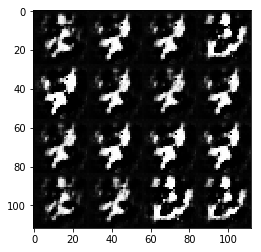

Epoch 1/2 ---  Discriminator loss: 0.1505 Generator loss: 3.4140
Epoch 1/2 ---  Discriminator loss: 1.0184 Generator loss: 0.5534
Epoch 1/2 ---  Discriminator loss: 0.7620 Generator loss: 0.8120
Epoch 1/2 ---  Discriminator loss: 0.2693 Generator loss: 1.9708
Epoch 1/2 ---  Discriminator loss: 0.3303 Generator loss: 4.7800
Epoch 1/2 ---  Discriminator loss: 0.3839 Generator loss: 2.6336
Epoch 1/2 ---  Discriminator loss: 0.2549 Generator loss: 2.0159
Epoch 1/2 ---  Discriminator loss: 1.0074 Generator loss: 0.5258
Epoch 1/2 ---  Discriminator loss: 0.4405 Generator loss: 7.2041
Epoch 1/2 ---  Discriminator loss: 0.4881 Generator loss: 1.3855


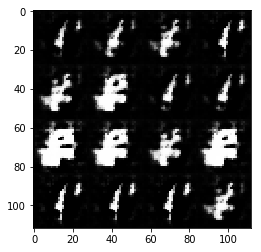

Epoch 1/2 ---  Discriminator loss: 0.3808 Generator loss: 1.4267
Epoch 1/2 ---  Discriminator loss: 0.2134 Generator loss: 3.7695
Epoch 1/2 ---  Discriminator loss: 1.0391 Generator loss: 0.9862
Epoch 1/2 ---  Discriminator loss: 2.2159 Generator loss: 14.8016
Epoch 1/2 ---  Discriminator loss: 0.3007 Generator loss: 2.2959
Epoch 1/2 ---  Discriminator loss: 0.2937 Generator loss: 1.8144
Epoch 1/2 ---  Discriminator loss: 0.4603 Generator loss: 1.4522
Epoch 1/2 ---  Discriminator loss: 0.2021 Generator loss: 2.1901
Epoch 1/2 ---  Discriminator loss: 0.6328 Generator loss: 0.9473
Epoch 1/2 ---  Discriminator loss: 0.7960 Generator loss: 6.2071


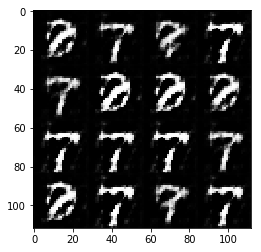

Epoch 1/2 ---  Discriminator loss: 0.2493 Generator loss: 2.9804
Epoch 1/2 ---  Discriminator loss: 0.3221 Generator loss: 1.7633
Epoch 1/2 ---  Discriminator loss: 0.5800 Generator loss: 1.3828
Epoch 1/2 ---  Discriminator loss: 0.2093 Generator loss: 2.4586
Epoch 1/2 ---  Discriminator loss: 0.9986 Generator loss: 7.3916
Epoch 1/2 ---  Discriminator loss: 0.4850 Generator loss: 1.4850
Epoch 1/2 ---  Discriminator loss: 0.5894 Generator loss: 1.3315
Epoch 1/2 ---  Discriminator loss: 0.4479 Generator loss: 1.3127
Epoch 1/2 ---  Discriminator loss: 0.5002 Generator loss: 2.5638
Epoch 1/2 ---  Discriminator loss: 0.3086 Generator loss: 3.5779


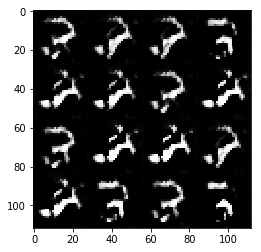

Epoch 1/2 ---  Discriminator loss: 0.3464 Generator loss: 1.5820
Epoch 1/2 ---  Discriminator loss: 0.3346 Generator loss: 3.3906
Epoch 1/2 ---  Discriminator loss: 0.7150 Generator loss: 1.0905
Epoch 1/2 ---  Discriminator loss: 0.1457 Generator loss: 3.2733
Epoch 1/2 ---  Discriminator loss: 0.3665 Generator loss: 2.1062
Epoch 1/2 ---  Discriminator loss: 0.2311 Generator loss: 2.6283
Epoch 1/2 ---  Discriminator loss: 0.3434 Generator loss: 2.0502
Epoch 1/2 ---  Discriminator loss: 0.7410 Generator loss: 0.7381
Epoch 1/2 ---  Discriminator loss: 0.3827 Generator loss: 1.4874
Epoch 1/2 ---  Discriminator loss: 0.3615 Generator loss: 2.2606


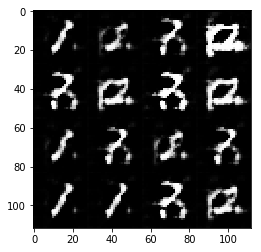

Epoch 1/2 ---  Discriminator loss: 0.5800 Generator loss: 1.1382
Epoch 1/2 ---  Discriminator loss: 0.4841 Generator loss: 1.6051
Epoch 1/2 ---  Discriminator loss: 1.5049 Generator loss: 7.8380
Epoch 1/2 ---  Discriminator loss: 0.3161 Generator loss: 5.2650
Epoch 1/2 ---  Discriminator loss: 0.2735 Generator loss: 5.1163
Epoch 1/2 ---  Discriminator loss: 0.4292 Generator loss: 1.5547
Epoch 1/2 ---  Discriminator loss: 0.2364 Generator loss: 2.3708
Epoch 1/2 ---  Discriminator loss: 0.3967 Generator loss: 1.7529
Epoch 1/2 ---  Discriminator loss: 0.3375 Generator loss: 1.8601
Epoch 1/2 ---  Discriminator loss: 0.4019 Generator loss: 2.9483


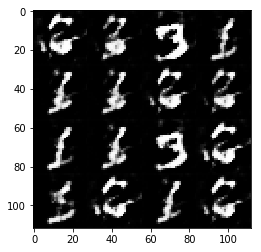

Epoch 1/2 ---  Discriminator loss: 1.1911 Generator loss: 7.3109
Epoch 1/2 ---  Discriminator loss: 0.5878 Generator loss: 1.7257
Epoch 1/2 ---  Discriminator loss: 0.3273 Generator loss: 2.8046
Epoch 1/2 ---  Discriminator loss: 0.5826 Generator loss: 1.2034
Epoch 1/2 ---  Discriminator loss: 0.3431 Generator loss: 1.8882
Epoch 1/2 ---  Discriminator loss: 0.6587 Generator loss: 7.9073
Epoch 1/2 ---  Discriminator loss: 1.0940 Generator loss: 5.7945
Epoch 1/2 ---  Discriminator loss: 0.9553 Generator loss: 1.0715
Epoch 1/2 ---  Discriminator loss: 0.8694 Generator loss: 0.7936
Epoch 1/2 ---  Discriminator loss: 0.7461 Generator loss: 6.1086


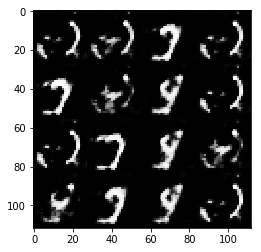

Epoch 1/2 ---  Discriminator loss: 0.2828 Generator loss: 2.3162
Epoch 1/2 ---  Discriminator loss: 0.3589 Generator loss: 2.5178
Epoch 1/2 ---  Discriminator loss: 0.3791 Generator loss: 2.7226
Epoch 1/2 ---  Discriminator loss: 0.3990 Generator loss: 3.5472
Epoch 1/2 ---  Discriminator loss: 0.3681 Generator loss: 1.7065
Epoch 1/2 ---  Discriminator loss: 0.2420 Generator loss: 1.9523
Epoch 1/2 ---  Discriminator loss: 0.8382 Generator loss: 7.6854
Epoch 1/2 ---  Discriminator loss: 0.7028 Generator loss: 1.9266
Epoch 1/2 ---  Discriminator loss: 1.0128 Generator loss: 0.6916
Epoch 1/2 ---  Discriminator loss: 0.3980 Generator loss: 1.8487


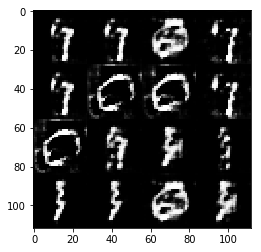

Epoch 1/2 ---  Discriminator loss: 0.5208 Generator loss: 2.2279
Epoch 1/2 ---  Discriminator loss: 0.5797 Generator loss: 1.1778
Epoch 1/2 ---  Discriminator loss: 1.5671 Generator loss: 0.3698
Epoch 1/2 ---  Discriminator loss: 1.1836 Generator loss: 4.4960
Epoch 1/2 ---  Discriminator loss: 0.5520 Generator loss: 1.5486
Epoch 1/2 ---  Discriminator loss: 2.0685 Generator loss: 0.2929
Epoch 1/2 ---  Discriminator loss: 0.4540 Generator loss: 1.4940
Epoch 1/2 ---  Discriminator loss: 1.3207 Generator loss: 0.3852
Epoch 1/2 ---  Discriminator loss: 0.7551 Generator loss: 3.1566
Epoch 1/2 ---  Discriminator loss: 0.3242 Generator loss: 3.2589


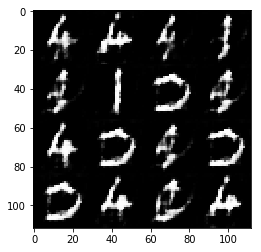

Epoch 1/2 ---  Discriminator loss: 0.3557 Generator loss: 1.6894
Epoch 1/2 ---  Discriminator loss: 1.3787 Generator loss: 7.1591
Epoch 1/2 ---  Discriminator loss: 0.4479 Generator loss: 1.4586
Epoch 1/2 ---  Discriminator loss: 0.3875 Generator loss: 1.9904
Epoch 1/2 ---  Discriminator loss: 0.4715 Generator loss: 2.7525
Epoch 1/2 ---  Discriminator loss: 0.6547 Generator loss: 1.3233
Epoch 1/2 ---  Discriminator loss: 0.7658 Generator loss: 4.0895
Epoch 1/2 ---  Discriminator loss: 1.2247 Generator loss: 0.6331
Epoch 1/2 ---  Discriminator loss: 0.3641 Generator loss: 1.7181
Epoch 1/2 ---  Discriminator loss: 0.3633 Generator loss: 4.0039


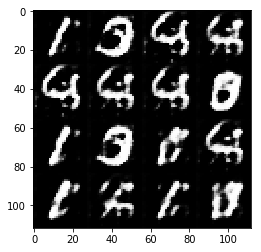

Epoch 1/2 ---  Discriminator loss: 0.6183 Generator loss: 2.5531
Epoch 1/2 ---  Discriminator loss: 0.9779 Generator loss: 6.9426
Epoch 1/2 ---  Discriminator loss: 0.5068 Generator loss: 1.2153
Epoch 1/2 ---  Discriminator loss: 0.3754 Generator loss: 3.0598
Epoch 1/2 ---  Discriminator loss: 0.4680 Generator loss: 3.8135
Epoch 1/2 ---  Discriminator loss: 0.4743 Generator loss: 2.0433
Epoch 1/2 ---  Discriminator loss: 0.5959 Generator loss: 2.4848
Epoch 1/2 ---  Discriminator loss: 0.7794 Generator loss: 0.8650
Epoch 1/2 ---  Discriminator loss: 0.4233 Generator loss: 1.4224
Epoch 1/2 ---  Discriminator loss: 0.2676 Generator loss: 2.5090


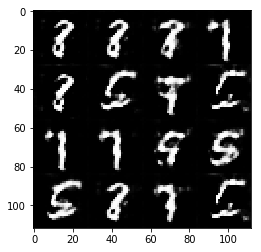

Epoch 1/2 ---  Discriminator loss: 0.3423 Generator loss: 1.7288
Epoch 1/2 ---  Discriminator loss: 0.3941 Generator loss: 3.2018
Epoch 1/2 ---  Discriminator loss: 0.6129 Generator loss: 1.4498
Epoch 1/2 ---  Discriminator loss: 0.5729 Generator loss: 1.8744
Epoch 1/2 ---  Discriminator loss: 0.4840 Generator loss: 2.5057
Epoch 1/2 ---  Discriminator loss: 0.8624 Generator loss: 0.6944
Epoch 1/2 ---  Discriminator loss: 0.3732 Generator loss: 3.0922
Epoch 1/2 ---  Discriminator loss: 0.2179 Generator loss: 3.4132
Epoch 1/2 ---  Discriminator loss: 0.9707 Generator loss: 0.7660
Epoch 1/2 ---  Discriminator loss: 0.8707 Generator loss: 0.8919


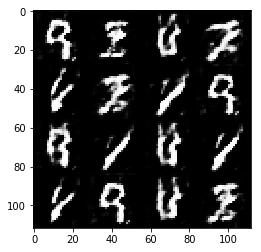

Epoch 1/2 ---  Discriminator loss: 1.3341 Generator loss: 0.6422
Epoch 1/2 ---  Discriminator loss: 0.4315 Generator loss: 1.8451
Epoch 1/2 ---  Discriminator loss: 0.7351 Generator loss: 2.5665
Epoch 1/2 ---  Discriminator loss: 0.5192 Generator loss: 2.8775
Epoch 1/2 ---  Discriminator loss: 0.5416 Generator loss: 1.9244
Epoch 1/2 ---  Discriminator loss: 0.4178 Generator loss: 1.8169
Epoch 1/2 ---  Discriminator loss: 0.2821 Generator loss: 2.9878
Epoch 2/2 ---  Discriminator loss: 0.4231 Generator loss: 2.2450
Epoch 2/2 ---  Discriminator loss: 0.3579 Generator loss: 2.9860
Epoch 2/2 ---  Discriminator loss: 0.5612 Generator loss: 3.9432


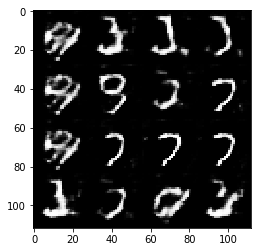

Epoch 2/2 ---  Discriminator loss: 0.3916 Generator loss: 3.0391
Epoch 2/2 ---  Discriminator loss: 0.3605 Generator loss: 2.6353
Epoch 2/2 ---  Discriminator loss: 1.7591 Generator loss: 6.4696
Epoch 2/2 ---  Discriminator loss: 0.3472 Generator loss: 1.8770
Epoch 2/2 ---  Discriminator loss: 0.7957 Generator loss: 1.0704
Epoch 2/2 ---  Discriminator loss: 0.5023 Generator loss: 1.1707
Epoch 2/2 ---  Discriminator loss: 0.3668 Generator loss: 2.1456
Epoch 2/2 ---  Discriminator loss: 0.4065 Generator loss: 1.9907
Epoch 2/2 ---  Discriminator loss: 0.3003 Generator loss: 2.6490
Epoch 2/2 ---  Discriminator loss: 0.3889 Generator loss: 3.1420


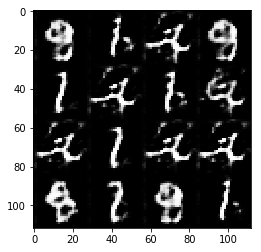

Epoch 2/2 ---  Discriminator loss: 0.2974 Generator loss: 4.9272
Epoch 2/2 ---  Discriminator loss: 0.5241 Generator loss: 3.6375
Epoch 2/2 ---  Discriminator loss: 1.8387 Generator loss: 0.3153
Epoch 2/2 ---  Discriminator loss: 0.3803 Generator loss: 1.6183
Epoch 2/2 ---  Discriminator loss: 0.6497 Generator loss: 1.1839
Epoch 2/2 ---  Discriminator loss: 0.8344 Generator loss: 1.6069
Epoch 2/2 ---  Discriminator loss: 0.5182 Generator loss: 1.6312
Epoch 2/2 ---  Discriminator loss: 0.8434 Generator loss: 0.8791
Epoch 2/2 ---  Discriminator loss: 0.3236 Generator loss: 1.7868
Epoch 2/2 ---  Discriminator loss: 0.6495 Generator loss: 2.7964


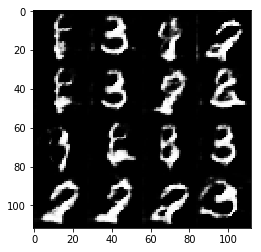

Epoch 2/2 ---  Discriminator loss: 0.5731 Generator loss: 1.2826
Epoch 2/2 ---  Discriminator loss: 0.8049 Generator loss: 4.0111
Epoch 2/2 ---  Discriminator loss: 1.0189 Generator loss: 0.5832
Epoch 2/2 ---  Discriminator loss: 0.7613 Generator loss: 1.3254
Epoch 2/2 ---  Discriminator loss: 0.6508 Generator loss: 2.4434
Epoch 2/2 ---  Discriminator loss: 1.3679 Generator loss: 0.4448
Epoch 2/2 ---  Discriminator loss: 0.7739 Generator loss: 0.7813
Epoch 2/2 ---  Discriminator loss: 1.0866 Generator loss: 0.6939
Epoch 2/2 ---  Discriminator loss: 0.4690 Generator loss: 1.8452
Epoch 2/2 ---  Discriminator loss: 0.8125 Generator loss: 2.3541


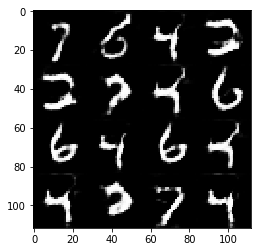

Epoch 2/2 ---  Discriminator loss: 0.6673 Generator loss: 2.4574
Epoch 2/2 ---  Discriminator loss: 0.5645 Generator loss: 3.1210
Epoch 2/2 ---  Discriminator loss: 0.8372 Generator loss: 0.8751
Epoch 2/2 ---  Discriminator loss: 0.7353 Generator loss: 1.1729
Epoch 2/2 ---  Discriminator loss: 0.5628 Generator loss: 2.5393
Epoch 2/2 ---  Discriminator loss: 0.8231 Generator loss: 0.9570
Epoch 2/2 ---  Discriminator loss: 1.0011 Generator loss: 0.6805
Epoch 2/2 ---  Discriminator loss: 0.9769 Generator loss: 1.1342
Epoch 2/2 ---  Discriminator loss: 1.0460 Generator loss: 0.6188
Epoch 2/2 ---  Discriminator loss: 1.0720 Generator loss: 0.6811


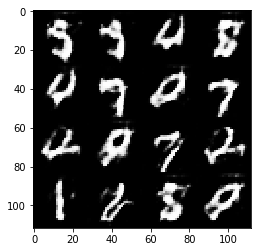

Epoch 2/2 ---  Discriminator loss: 0.3976 Generator loss: 2.6350
Epoch 2/2 ---  Discriminator loss: 0.7690 Generator loss: 2.4773
Epoch 2/2 ---  Discriminator loss: 0.9411 Generator loss: 0.7519
Epoch 2/2 ---  Discriminator loss: 0.5867 Generator loss: 2.5833
Epoch 2/2 ---  Discriminator loss: 0.8910 Generator loss: 0.8975
Epoch 2/2 ---  Discriminator loss: 0.5744 Generator loss: 2.3127
Epoch 2/2 ---  Discriminator loss: 0.6338 Generator loss: 1.0304
Epoch 2/2 ---  Discriminator loss: 0.6047 Generator loss: 2.5228
Epoch 2/2 ---  Discriminator loss: 0.8490 Generator loss: 0.9671
Epoch 2/2 ---  Discriminator loss: 1.8245 Generator loss: 0.1977


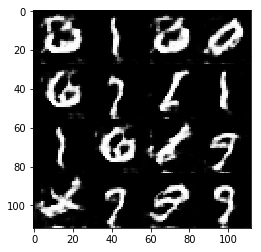

Epoch 2/2 ---  Discriminator loss: 0.9245 Generator loss: 0.9190
Epoch 2/2 ---  Discriminator loss: 0.7833 Generator loss: 0.8942
Epoch 2/2 ---  Discriminator loss: 1.4427 Generator loss: 0.4461
Epoch 2/2 ---  Discriminator loss: 0.6210 Generator loss: 1.3605
Epoch 2/2 ---  Discriminator loss: 1.2175 Generator loss: 0.6236
Epoch 2/2 ---  Discriminator loss: 0.6667 Generator loss: 1.2474
Epoch 2/2 ---  Discriminator loss: 0.6677 Generator loss: 0.9470
Epoch 2/2 ---  Discriminator loss: 1.2451 Generator loss: 0.5764
Epoch 2/2 ---  Discriminator loss: 0.8931 Generator loss: 0.7663
Epoch 2/2 ---  Discriminator loss: 0.7955 Generator loss: 0.9918


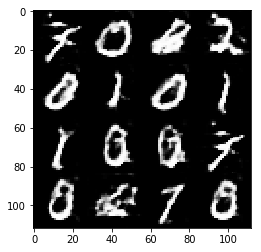

Epoch 2/2 ---  Discriminator loss: 1.0791 Generator loss: 0.5339
Epoch 2/2 ---  Discriminator loss: 0.4392 Generator loss: 1.5619
Epoch 2/2 ---  Discriminator loss: 0.7225 Generator loss: 1.2082
Epoch 2/2 ---  Discriminator loss: 0.9689 Generator loss: 0.7188
Epoch 2/2 ---  Discriminator loss: 0.4853 Generator loss: 1.3548
Epoch 2/2 ---  Discriminator loss: 1.4130 Generator loss: 0.4356
Epoch 2/2 ---  Discriminator loss: 0.6900 Generator loss: 1.0073
Epoch 2/2 ---  Discriminator loss: 1.2761 Generator loss: 0.5172
Epoch 2/2 ---  Discriminator loss: 0.4991 Generator loss: 1.7980
Epoch 2/2 ---  Discriminator loss: 1.3307 Generator loss: 0.3988


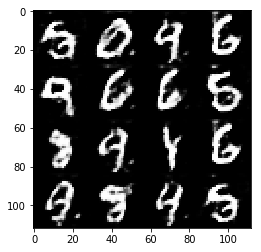

Epoch 2/2 ---  Discriminator loss: 0.4649 Generator loss: 3.4013
Epoch 2/2 ---  Discriminator loss: 1.8102 Generator loss: 5.9970
Epoch 2/2 ---  Discriminator loss: 1.2538 Generator loss: 0.4389
Epoch 2/2 ---  Discriminator loss: 0.7774 Generator loss: 1.1909
Epoch 2/2 ---  Discriminator loss: 1.3555 Generator loss: 0.3622
Epoch 2/2 ---  Discriminator loss: 0.4227 Generator loss: 2.3610
Epoch 2/2 ---  Discriminator loss: 1.0750 Generator loss: 0.6542
Epoch 2/2 ---  Discriminator loss: 0.7196 Generator loss: 1.2596
Epoch 2/2 ---  Discriminator loss: 0.6682 Generator loss: 2.1965
Epoch 2/2 ---  Discriminator loss: 0.3554 Generator loss: 2.4656


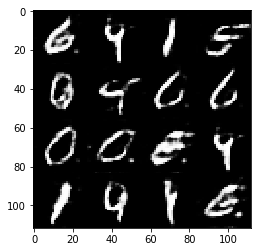

Epoch 2/2 ---  Discriminator loss: 0.9319 Generator loss: 0.6941
Epoch 2/2 ---  Discriminator loss: 0.7946 Generator loss: 1.0840
Epoch 2/2 ---  Discriminator loss: 0.5979 Generator loss: 1.4142
Epoch 2/2 ---  Discriminator loss: 0.6190 Generator loss: 1.3603
Epoch 2/2 ---  Discriminator loss: 1.1610 Generator loss: 0.4700
Epoch 2/2 ---  Discriminator loss: 0.6168 Generator loss: 2.5889
Epoch 2/2 ---  Discriminator loss: 1.2320 Generator loss: 0.4409
Epoch 2/2 ---  Discriminator loss: 0.4890 Generator loss: 1.3976
Epoch 2/2 ---  Discriminator loss: 0.6188 Generator loss: 1.1648
Epoch 2/2 ---  Discriminator loss: 1.2483 Generator loss: 0.6643


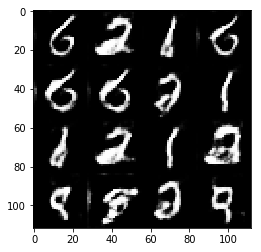

Epoch 2/2 ---  Discriminator loss: 1.1387 Generator loss: 3.7391
Epoch 2/2 ---  Discriminator loss: 0.7687 Generator loss: 1.0732
Epoch 2/2 ---  Discriminator loss: 0.4517 Generator loss: 1.6960
Epoch 2/2 ---  Discriminator loss: 1.0241 Generator loss: 0.7116
Epoch 2/2 ---  Discriminator loss: 1.2425 Generator loss: 3.1827
Epoch 2/2 ---  Discriminator loss: 1.2760 Generator loss: 0.4470
Epoch 2/2 ---  Discriminator loss: 0.6109 Generator loss: 1.6174
Epoch 2/2 ---  Discriminator loss: 1.1531 Generator loss: 3.7002
Epoch 2/2 ---  Discriminator loss: 0.9544 Generator loss: 3.8850
Epoch 2/2 ---  Discriminator loss: 0.7112 Generator loss: 1.0321


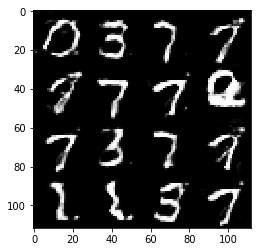

Epoch 2/2 ---  Discriminator loss: 0.6136 Generator loss: 2.0414
Epoch 2/2 ---  Discriminator loss: 0.6855 Generator loss: 1.4276
Epoch 2/2 ---  Discriminator loss: 0.6066 Generator loss: 2.2996
Epoch 2/2 ---  Discriminator loss: 1.3956 Generator loss: 0.3587
Epoch 2/2 ---  Discriminator loss: 1.2168 Generator loss: 0.5049
Epoch 2/2 ---  Discriminator loss: 0.5703 Generator loss: 1.1957
Epoch 2/2 ---  Discriminator loss: 0.6890 Generator loss: 0.9611
Epoch 2/2 ---  Discriminator loss: 0.8118 Generator loss: 1.1635
Epoch 2/2 ---  Discriminator loss: 2.0212 Generator loss: 0.2786
Epoch 2/2 ---  Discriminator loss: 0.5989 Generator loss: 1.2673


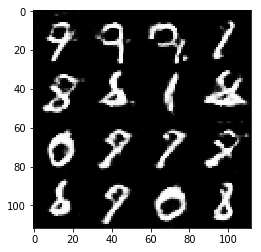

Epoch 2/2 ---  Discriminator loss: 0.9158 Generator loss: 0.7006
Epoch 2/2 ---  Discriminator loss: 0.5551 Generator loss: 1.2596
Epoch 2/2 ---  Discriminator loss: 0.9095 Generator loss: 1.5720
Epoch 2/2 ---  Discriminator loss: 1.2352 Generator loss: 0.4587
Epoch 2/2 ---  Discriminator loss: 1.5279 Generator loss: 0.3467
Epoch 2/2 ---  Discriminator loss: 0.7013 Generator loss: 1.0389
Epoch 2/2 ---  Discriminator loss: 0.6657 Generator loss: 1.0786
Epoch 2/2 ---  Discriminator loss: 0.6113 Generator loss: 0.9910
Epoch 2/2 ---  Discriminator loss: 1.5386 Generator loss: 0.3560
Epoch 2/2 ---  Discriminator loss: 0.5193 Generator loss: 1.6204


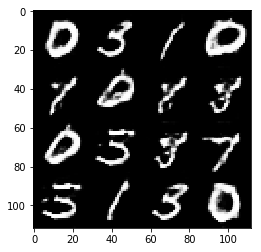

Epoch 2/2 ---  Discriminator loss: 0.7286 Generator loss: 1.2213
Epoch 2/2 ---  Discriminator loss: 1.0698 Generator loss: 0.6018
Epoch 2/2 ---  Discriminator loss: 0.7382 Generator loss: 1.9245
Epoch 2/2 ---  Discriminator loss: 0.8329 Generator loss: 4.3648
Epoch 2/2 ---  Discriminator loss: 0.9673 Generator loss: 0.6001
Epoch 2/2 ---  Discriminator loss: 0.6113 Generator loss: 1.0496
Epoch 2/2 ---  Discriminator loss: 0.5863 Generator loss: 1.0369
Epoch 2/2 ---  Discriminator loss: 0.4309 Generator loss: 1.5587
Epoch 2/2 ---  Discriminator loss: 0.5368 Generator loss: 2.7268
Epoch 2/2 ---  Discriminator loss: 0.4483 Generator loss: 1.8213


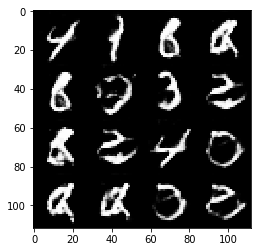

Epoch 2/2 ---  Discriminator loss: 0.6043 Generator loss: 1.0964
Epoch 2/2 ---  Discriminator loss: 0.6097 Generator loss: 1.0750
Epoch 2/2 ---  Discriminator loss: 1.4466 Generator loss: 0.7792
Epoch 2/2 ---  Discriminator loss: 0.4768 Generator loss: 1.5188
Epoch 2/2 ---  Discriminator loss: 1.1668 Generator loss: 0.4970
Epoch 2/2 ---  Discriminator loss: 0.5982 Generator loss: 1.1324
Epoch 2/2 ---  Discriminator loss: 1.0967 Generator loss: 0.5569
Epoch 2/2 ---  Discriminator loss: 1.1614 Generator loss: 0.5061
Epoch 2/2 ---  Discriminator loss: 1.2561 Generator loss: 0.5568
Epoch 2/2 ---  Discriminator loss: 0.6052 Generator loss: 1.9314


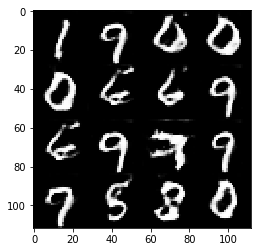

Epoch 2/2 ---  Discriminator loss: 0.9622 Generator loss: 2.4719
Epoch 2/2 ---  Discriminator loss: 0.9667 Generator loss: 2.6945
Epoch 2/2 ---  Discriminator loss: 0.6168 Generator loss: 1.4053
Epoch 2/2 ---  Discriminator loss: 0.4560 Generator loss: 1.8552
Epoch 2/2 ---  Discriminator loss: 0.6687 Generator loss: 1.0761
Epoch 2/2 ---  Discriminator loss: 1.1206 Generator loss: 0.5187
Epoch 2/2 ---  Discriminator loss: 0.9153 Generator loss: 0.6447
Epoch 2/2 ---  Discriminator loss: 0.8102 Generator loss: 0.8070
Epoch 2/2 ---  Discriminator loss: 0.5826 Generator loss: 1.1287
Epoch 2/2 ---  Discriminator loss: 1.4030 Generator loss: 0.5060


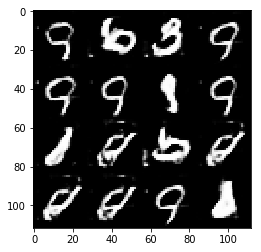

Epoch 2/2 ---  Discriminator loss: 0.5105 Generator loss: 2.0333
Epoch 2/2 ---  Discriminator loss: 0.4140 Generator loss: 1.5910
Epoch 2/2 ---  Discriminator loss: 0.4481 Generator loss: 1.5758
Epoch 2/2 ---  Discriminator loss: 0.8236 Generator loss: 0.9224
Epoch 2/2 ---  Discriminator loss: 0.4477 Generator loss: 1.5301
Epoch 2/2 ---  Discriminator loss: 0.7249 Generator loss: 1.0480
Epoch 2/2 ---  Discriminator loss: 0.7813 Generator loss: 3.0447
Epoch 2/2 ---  Discriminator loss: 0.7575 Generator loss: 0.9757
Epoch 2/2 ---  Discriminator loss: 0.7955 Generator loss: 0.9104
Epoch 2/2 ---  Discriminator loss: 1.0876 Generator loss: 0.6351


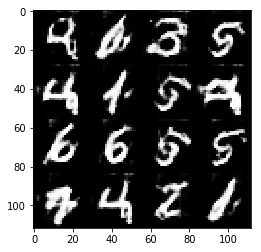

Epoch 2/2 ---  Discriminator loss: 0.4600 Generator loss: 1.5009
Epoch 2/2 ---  Discriminator loss: 1.2177 Generator loss: 4.5709
Epoch 2/2 ---  Discriminator loss: 1.6498 Generator loss: 0.2818
Epoch 2/2 ---  Discriminator loss: 1.0737 Generator loss: 0.5566
Epoch 2/2 ---  Discriminator loss: 0.6932 Generator loss: 2.4981
Epoch 2/2 ---  Discriminator loss: 0.4271 Generator loss: 2.6064
Epoch 2/2 ---  Discriminator loss: 0.5541 Generator loss: 2.5522
Epoch 2/2 ---  Discriminator loss: 0.4979 Generator loss: 1.7529
Epoch 2/2 ---  Discriminator loss: 0.8219 Generator loss: 0.9057
Epoch 2/2 ---  Discriminator loss: 0.7017 Generator loss: 2.2994


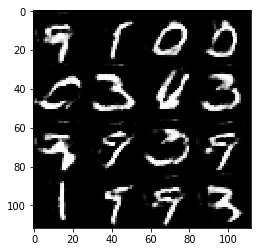

Epoch 2/2 ---  Discriminator loss: 0.6753 Generator loss: 1.0906
Epoch 2/2 ---  Discriminator loss: 0.6347 Generator loss: 2.6305
Epoch 2/2 ---  Discriminator loss: 0.6252 Generator loss: 3.8335
Epoch 2/2 ---  Discriminator loss: 0.6588 Generator loss: 1.1225
Epoch 2/2 ---  Discriminator loss: 0.7823 Generator loss: 0.7454
Epoch 2/2 ---  Discriminator loss: 0.9742 Generator loss: 0.7271
Epoch 2/2 ---  Discriminator loss: 0.3470 Generator loss: 1.9086
Epoch 2/2 ---  Discriminator loss: 0.7840 Generator loss: 0.8662
Epoch 2/2 ---  Discriminator loss: 0.5736 Generator loss: 1.3214
Epoch 2/2 ---  Discriminator loss: 0.7838 Generator loss: 0.8458


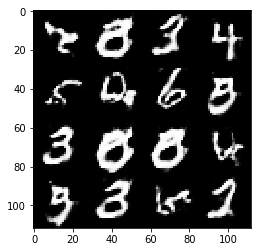

Epoch 2/2 ---  Discriminator loss: 0.4962 Generator loss: 2.5244
Epoch 2/2 ---  Discriminator loss: 0.4222 Generator loss: 1.6009
Epoch 2/2 ---  Discriminator loss: 0.8993 Generator loss: 0.6657
Epoch 2/2 ---  Discriminator loss: 0.7852 Generator loss: 0.7573
Epoch 2/2 ---  Discriminator loss: 0.4557 Generator loss: 1.8934


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 ---  Discriminator loss: 0.3201 Generator loss: 3.9455
Epoch 1/1 ---  Discriminator loss: 9.8530 Generator loss: 0.0001
Epoch 1/1 ---  Discriminator loss: 3.5018 Generator loss: 13.6409
Epoch 1/1 ---  Discriminator loss: 3.2395 Generator loss: 0.1115
Epoch 1/1 ---  Discriminator loss: 1.3759 Generator loss: 0.4937
Epoch 1/1 ---  Discriminator loss: 1.2472 Generator loss: 0.7287
Epoch 1/1 ---  Discriminator loss: 2.7516 Generator loss: 0.1170
Epoch 1/1 ---  Discriminator loss: 1.5441 Generator loss: 0.5009
Epoch 1/1 ---  Discriminator loss: 1.6166 Generator loss: 0.3382
Epoch 1/1 ---  Discriminator loss: 1.7340 Generator loss: 0.5087


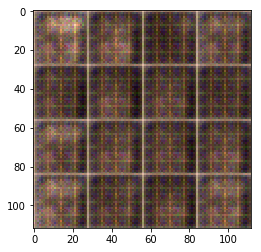

Epoch 1/1 ---  Discriminator loss: 2.0162 Generator loss: 0.6476
Epoch 1/1 ---  Discriminator loss: 1.8611 Generator loss: 0.8727
Epoch 1/1 ---  Discriminator loss: 1.6261 Generator loss: 0.4844
Epoch 1/1 ---  Discriminator loss: 1.8389 Generator loss: 0.3610
Epoch 1/1 ---  Discriminator loss: 1.5247 Generator loss: 0.8441
Epoch 1/1 ---  Discriminator loss: 1.4929 Generator loss: 0.4306
Epoch 1/1 ---  Discriminator loss: 1.5038 Generator loss: 0.4884
Epoch 1/1 ---  Discriminator loss: 1.5284 Generator loss: 0.7112
Epoch 1/1 ---  Discriminator loss: 1.2795 Generator loss: 0.8019
Epoch 1/1 ---  Discriminator loss: 2.1624 Generator loss: 0.1669


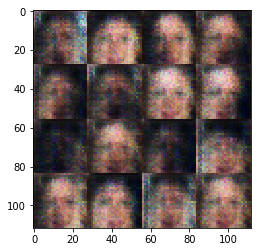

Epoch 1/1 ---  Discriminator loss: 1.4290 Generator loss: 0.7017
Epoch 1/1 ---  Discriminator loss: 1.3909 Generator loss: 0.9294
Epoch 1/1 ---  Discriminator loss: 1.2684 Generator loss: 1.1268
Epoch 1/1 ---  Discriminator loss: 1.2873 Generator loss: 0.8866
Epoch 1/1 ---  Discriminator loss: 1.4520 Generator loss: 1.0907
Epoch 1/1 ---  Discriminator loss: 1.8669 Generator loss: 0.7511
Epoch 1/1 ---  Discriminator loss: 1.7541 Generator loss: 0.6663
Epoch 1/1 ---  Discriminator loss: 1.2002 Generator loss: 0.8274
Epoch 1/1 ---  Discriminator loss: 1.4935 Generator loss: 0.3869
Epoch 1/1 ---  Discriminator loss: 1.2487 Generator loss: 0.7274


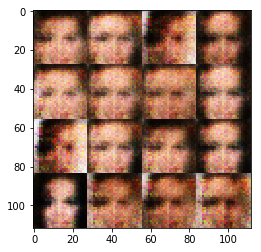

Epoch 1/1 ---  Discriminator loss: 1.2575 Generator loss: 0.7653
Epoch 1/1 ---  Discriminator loss: 1.4748 Generator loss: 0.4712
Epoch 1/1 ---  Discriminator loss: 1.6780 Generator loss: 0.4872
Epoch 1/1 ---  Discriminator loss: 1.4199 Generator loss: 0.4492
Epoch 1/1 ---  Discriminator loss: 1.5169 Generator loss: 0.4655
Epoch 1/1 ---  Discriminator loss: 1.1734 Generator loss: 0.9171
Epoch 1/1 ---  Discriminator loss: 1.3909 Generator loss: 0.5825
Epoch 1/1 ---  Discriminator loss: 1.5051 Generator loss: 0.5652
Epoch 1/1 ---  Discriminator loss: 1.3892 Generator loss: 0.8610
Epoch 1/1 ---  Discriminator loss: 1.6469 Generator loss: 1.5141


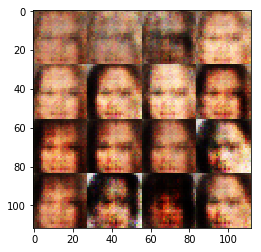

Epoch 1/1 ---  Discriminator loss: 1.2367 Generator loss: 0.7037
Epoch 1/1 ---  Discriminator loss: 1.2195 Generator loss: 0.8191
Epoch 1/1 ---  Discriminator loss: 1.4189 Generator loss: 0.5093
Epoch 1/1 ---  Discriminator loss: 1.4472 Generator loss: 0.6840
Epoch 1/1 ---  Discriminator loss: 1.2098 Generator loss: 0.9686
Epoch 1/1 ---  Discriminator loss: 1.2936 Generator loss: 0.7495
Epoch 1/1 ---  Discriminator loss: 1.2564 Generator loss: 0.6587
Epoch 1/1 ---  Discriminator loss: 1.1385 Generator loss: 1.0904
Epoch 1/1 ---  Discriminator loss: 1.2209 Generator loss: 0.6215
Epoch 1/1 ---  Discriminator loss: 1.4601 Generator loss: 0.4539


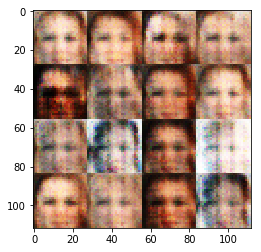

Epoch 1/1 ---  Discriminator loss: 1.3153 Generator loss: 0.6065
Epoch 1/1 ---  Discriminator loss: 1.2459 Generator loss: 0.8591
Epoch 1/1 ---  Discriminator loss: 1.3399 Generator loss: 0.7187
Epoch 1/1 ---  Discriminator loss: 1.6987 Generator loss: 0.3390
Epoch 1/1 ---  Discriminator loss: 1.4843 Generator loss: 0.5098
Epoch 1/1 ---  Discriminator loss: 1.4948 Generator loss: 0.4641
Epoch 1/1 ---  Discriminator loss: 1.3492 Generator loss: 0.5682
Epoch 1/1 ---  Discriminator loss: 1.4581 Generator loss: 0.6964
Epoch 1/1 ---  Discriminator loss: 1.6155 Generator loss: 0.5434
Epoch 1/1 ---  Discriminator loss: 1.7501 Generator loss: 0.9648


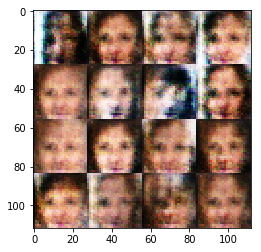

Epoch 1/1 ---  Discriminator loss: 1.4404 Generator loss: 0.4844
Epoch 1/1 ---  Discriminator loss: 1.2727 Generator loss: 0.7628
Epoch 1/1 ---  Discriminator loss: 1.4328 Generator loss: 0.4183
Epoch 1/1 ---  Discriminator loss: 1.5843 Generator loss: 0.4267
Epoch 1/1 ---  Discriminator loss: 1.4754 Generator loss: 0.9164
Epoch 1/1 ---  Discriminator loss: 1.5447 Generator loss: 0.7911
Epoch 1/1 ---  Discriminator loss: 1.3350 Generator loss: 0.6115
Epoch 1/1 ---  Discriminator loss: 1.3826 Generator loss: 1.1985
Epoch 1/1 ---  Discriminator loss: 1.5133 Generator loss: 0.7923
Epoch 1/1 ---  Discriminator loss: 1.2764 Generator loss: 0.8832


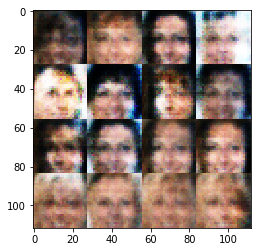

Epoch 1/1 ---  Discriminator loss: 1.2949 Generator loss: 0.6368
Epoch 1/1 ---  Discriminator loss: 1.2598 Generator loss: 0.9162
Epoch 1/1 ---  Discriminator loss: 1.2403 Generator loss: 0.9646
Epoch 1/1 ---  Discriminator loss: 1.2634 Generator loss: 0.7513
Epoch 1/1 ---  Discriminator loss: 1.1938 Generator loss: 0.9247
Epoch 1/1 ---  Discriminator loss: 1.4726 Generator loss: 1.3335
Epoch 1/1 ---  Discriminator loss: 1.2758 Generator loss: 0.7231
Epoch 1/1 ---  Discriminator loss: 1.4219 Generator loss: 0.5871
Epoch 1/1 ---  Discriminator loss: 1.4347 Generator loss: 0.6097
Epoch 1/1 ---  Discriminator loss: 1.3025 Generator loss: 0.5115


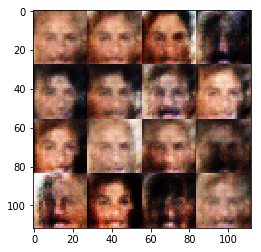

Epoch 1/1 ---  Discriminator loss: 1.3346 Generator loss: 0.5819
Epoch 1/1 ---  Discriminator loss: 1.3280 Generator loss: 0.7031
Epoch 1/1 ---  Discriminator loss: 1.4167 Generator loss: 0.6395
Epoch 1/1 ---  Discriminator loss: 1.2557 Generator loss: 0.7791
Epoch 1/1 ---  Discriminator loss: 1.2693 Generator loss: 0.5969
Epoch 1/1 ---  Discriminator loss: 1.6121 Generator loss: 0.3681
Epoch 1/1 ---  Discriminator loss: 1.2574 Generator loss: 0.6526
Epoch 1/1 ---  Discriminator loss: 1.3199 Generator loss: 1.1776
Epoch 1/1 ---  Discriminator loss: 1.4156 Generator loss: 0.5984
Epoch 1/1 ---  Discriminator loss: 1.2319 Generator loss: 0.7564


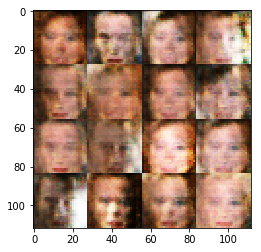

Epoch 1/1 ---  Discriminator loss: 1.2163 Generator loss: 1.0416
Epoch 1/1 ---  Discriminator loss: 1.3309 Generator loss: 0.5520
Epoch 1/1 ---  Discriminator loss: 1.2623 Generator loss: 0.7633
Epoch 1/1 ---  Discriminator loss: 1.3554 Generator loss: 0.6557
Epoch 1/1 ---  Discriminator loss: 1.2518 Generator loss: 0.6209
Epoch 1/1 ---  Discriminator loss: 1.3406 Generator loss: 0.7641
Epoch 1/1 ---  Discriminator loss: 1.5202 Generator loss: 0.9209
Epoch 1/1 ---  Discriminator loss: 1.4668 Generator loss: 1.0554
Epoch 1/1 ---  Discriminator loss: 1.1493 Generator loss: 0.9118
Epoch 1/1 ---  Discriminator loss: 1.4002 Generator loss: 0.8566


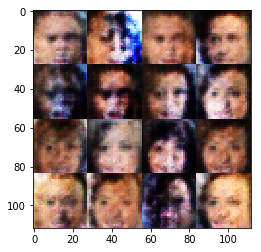

Epoch 1/1 ---  Discriminator loss: 1.2623 Generator loss: 0.5588
Epoch 1/1 ---  Discriminator loss: 1.3764 Generator loss: 1.2764
Epoch 1/1 ---  Discriminator loss: 1.1558 Generator loss: 0.7501
Epoch 1/1 ---  Discriminator loss: 1.5572 Generator loss: 0.7761
Epoch 1/1 ---  Discriminator loss: 1.3354 Generator loss: 0.7579
Epoch 1/1 ---  Discriminator loss: 1.4175 Generator loss: 0.7768
Epoch 1/1 ---  Discriminator loss: 1.3799 Generator loss: 0.5425
Epoch 1/1 ---  Discriminator loss: 1.4142 Generator loss: 0.8856
Epoch 1/1 ---  Discriminator loss: 1.2324 Generator loss: 0.6662
Epoch 1/1 ---  Discriminator loss: 1.2362 Generator loss: 0.7950


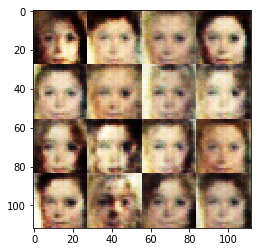

Epoch 1/1 ---  Discriminator loss: 1.2900 Generator loss: 0.7853
Epoch 1/1 ---  Discriminator loss: 1.4076 Generator loss: 0.6138
Epoch 1/1 ---  Discriminator loss: 1.4393 Generator loss: 0.5365
Epoch 1/1 ---  Discriminator loss: 1.2197 Generator loss: 0.6285
Epoch 1/1 ---  Discriminator loss: 1.2536 Generator loss: 0.6109
Epoch 1/1 ---  Discriminator loss: 1.3365 Generator loss: 0.5733
Epoch 1/1 ---  Discriminator loss: 1.4993 Generator loss: 0.9877
Epoch 1/1 ---  Discriminator loss: 1.4237 Generator loss: 0.6070
Epoch 1/1 ---  Discriminator loss: 1.2826 Generator loss: 1.0643
Epoch 1/1 ---  Discriminator loss: 1.2408 Generator loss: 0.7909


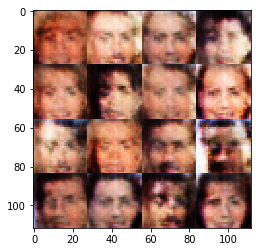

Epoch 1/1 ---  Discriminator loss: 1.2074 Generator loss: 0.7085
Epoch 1/1 ---  Discriminator loss: 1.4925 Generator loss: 0.4307
Epoch 1/1 ---  Discriminator loss: 1.4101 Generator loss: 0.6574
Epoch 1/1 ---  Discriminator loss: 1.5440 Generator loss: 0.4441
Epoch 1/1 ---  Discriminator loss: 1.3180 Generator loss: 0.5920
Epoch 1/1 ---  Discriminator loss: 1.2066 Generator loss: 0.8489
Epoch 1/1 ---  Discriminator loss: 1.1486 Generator loss: 0.6658
Epoch 1/1 ---  Discriminator loss: 1.2666 Generator loss: 0.7278
Epoch 1/1 ---  Discriminator loss: 1.1684 Generator loss: 0.8081
Epoch 1/1 ---  Discriminator loss: 1.4275 Generator loss: 0.7751


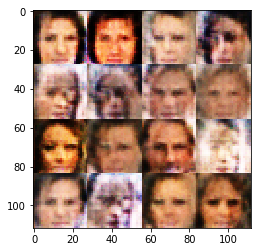

Epoch 1/1 ---  Discriminator loss: 1.3818 Generator loss: 0.5323
Epoch 1/1 ---  Discriminator loss: 1.3978 Generator loss: 0.5327
Epoch 1/1 ---  Discriminator loss: 1.3291 Generator loss: 0.5953
Epoch 1/1 ---  Discriminator loss: 1.2490 Generator loss: 0.6012
Epoch 1/1 ---  Discriminator loss: 1.5966 Generator loss: 0.3367
Epoch 1/1 ---  Discriminator loss: 1.4454 Generator loss: 0.4258
Epoch 1/1 ---  Discriminator loss: 1.3154 Generator loss: 0.7035
Epoch 1/1 ---  Discriminator loss: 1.3757 Generator loss: 0.5806
Epoch 1/1 ---  Discriminator loss: 1.3726 Generator loss: 0.6621
Epoch 1/1 ---  Discriminator loss: 1.2965 Generator loss: 0.6730


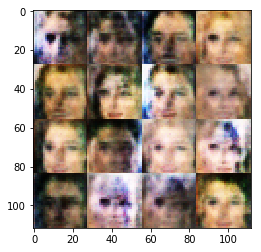

Epoch 1/1 ---  Discriminator loss: 1.3215 Generator loss: 0.8272
Epoch 1/1 ---  Discriminator loss: 1.6273 Generator loss: 0.3414
Epoch 1/1 ---  Discriminator loss: 1.3763 Generator loss: 0.6546
Epoch 1/1 ---  Discriminator loss: 1.4768 Generator loss: 0.4345
Epoch 1/1 ---  Discriminator loss: 1.2149 Generator loss: 0.8407
Epoch 1/1 ---  Discriminator loss: 1.4107 Generator loss: 1.0506
Epoch 1/1 ---  Discriminator loss: 1.3209 Generator loss: 0.9448
Epoch 1/1 ---  Discriminator loss: 1.3493 Generator loss: 0.6924
Epoch 1/1 ---  Discriminator loss: 1.4718 Generator loss: 0.9502
Epoch 1/1 ---  Discriminator loss: 1.2321 Generator loss: 0.8085


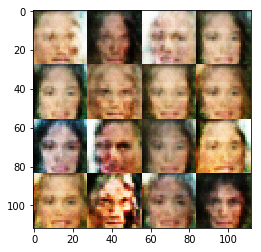

Epoch 1/1 ---  Discriminator loss: 1.2338 Generator loss: 0.9216
Epoch 1/1 ---  Discriminator loss: 1.4088 Generator loss: 0.9907
Epoch 1/1 ---  Discriminator loss: 1.2183 Generator loss: 0.7190
Epoch 1/1 ---  Discriminator loss: 1.3676 Generator loss: 0.6149
Epoch 1/1 ---  Discriminator loss: 1.2931 Generator loss: 0.4838
Epoch 1/1 ---  Discriminator loss: 1.2674 Generator loss: 0.6075
Epoch 1/1 ---  Discriminator loss: 1.1841 Generator loss: 0.6904
Epoch 1/1 ---  Discriminator loss: 1.4673 Generator loss: 0.6596
Epoch 1/1 ---  Discriminator loss: 1.3222 Generator loss: 0.9942
Epoch 1/1 ---  Discriminator loss: 1.1555 Generator loss: 0.9026


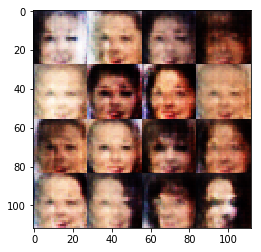

Epoch 1/1 ---  Discriminator loss: 1.3455 Generator loss: 0.9861
Epoch 1/1 ---  Discriminator loss: 1.0526 Generator loss: 0.9301
Epoch 1/1 ---  Discriminator loss: 1.2104 Generator loss: 1.0141
Epoch 1/1 ---  Discriminator loss: 1.2706 Generator loss: 0.8988
Epoch 1/1 ---  Discriminator loss: 1.3659 Generator loss: 0.6087
Epoch 1/1 ---  Discriminator loss: 1.2176 Generator loss: 0.8222
Epoch 1/1 ---  Discriminator loss: 1.2207 Generator loss: 0.5774
Epoch 1/1 ---  Discriminator loss: 1.4467 Generator loss: 0.4632
Epoch 1/1 ---  Discriminator loss: 1.2819 Generator loss: 0.8441
Epoch 1/1 ---  Discriminator loss: 1.2756 Generator loss: 0.8874


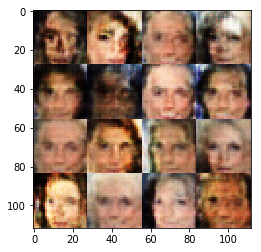

Epoch 1/1 ---  Discriminator loss: 1.2985 Generator loss: 0.7337
Epoch 1/1 ---  Discriminator loss: 1.2233 Generator loss: 1.1027
Epoch 1/1 ---  Discriminator loss: 1.2662 Generator loss: 0.8617
Epoch 1/1 ---  Discriminator loss: 1.2422 Generator loss: 0.6553
Epoch 1/1 ---  Discriminator loss: 1.3880 Generator loss: 0.7079
Epoch 1/1 ---  Discriminator loss: 1.2124 Generator loss: 0.8430
Epoch 1/1 ---  Discriminator loss: 1.2783 Generator loss: 0.8010
Epoch 1/1 ---  Discriminator loss: 1.2102 Generator loss: 0.7301
Epoch 1/1 ---  Discriminator loss: 1.3639 Generator loss: 1.0692
Epoch 1/1 ---  Discriminator loss: 1.4724 Generator loss: 1.1315


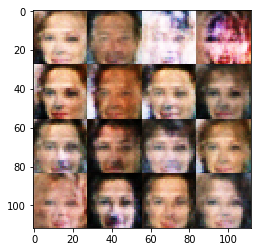

Epoch 1/1 ---  Discriminator loss: 1.4976 Generator loss: 0.3999
Epoch 1/1 ---  Discriminator loss: 1.2536 Generator loss: 0.6935
Epoch 1/1 ---  Discriminator loss: 1.4260 Generator loss: 1.4003
Epoch 1/1 ---  Discriminator loss: 1.2247 Generator loss: 0.6715
Epoch 1/1 ---  Discriminator loss: 1.2505 Generator loss: 0.7636
Epoch 1/1 ---  Discriminator loss: 1.2492 Generator loss: 1.1130
Epoch 1/1 ---  Discriminator loss: 1.1774 Generator loss: 0.7782
Epoch 1/1 ---  Discriminator loss: 1.3507 Generator loss: 0.6982
Epoch 1/1 ---  Discriminator loss: 1.3134 Generator loss: 0.8627
Epoch 1/1 ---  Discriminator loss: 1.2493 Generator loss: 0.9302


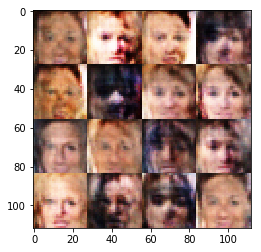

Epoch 1/1 ---  Discriminator loss: 1.3466 Generator loss: 0.7685
Epoch 1/1 ---  Discriminator loss: 1.2565 Generator loss: 0.9621
Epoch 1/1 ---  Discriminator loss: 1.4223 Generator loss: 0.6067
Epoch 1/1 ---  Discriminator loss: 1.2987 Generator loss: 0.7271
Epoch 1/1 ---  Discriminator loss: 1.3006 Generator loss: 0.8122
Epoch 1/1 ---  Discriminator loss: 1.4760 Generator loss: 0.4038
Epoch 1/1 ---  Discriminator loss: 1.3460 Generator loss: 0.9157
Epoch 1/1 ---  Discriminator loss: 1.2611 Generator loss: 0.6836
Epoch 1/1 ---  Discriminator loss: 1.3135 Generator loss: 1.1591
Epoch 1/1 ---  Discriminator loss: 1.2497 Generator loss: 0.7927


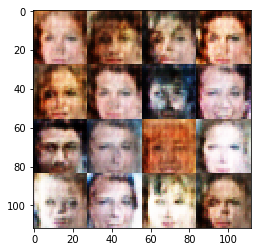

Epoch 1/1 ---  Discriminator loss: 1.4418 Generator loss: 0.8474
Epoch 1/1 ---  Discriminator loss: 1.2943 Generator loss: 0.6635
Epoch 1/1 ---  Discriminator loss: 1.4441 Generator loss: 0.4270
Epoch 1/1 ---  Discriminator loss: 1.1419 Generator loss: 0.7241
Epoch 1/1 ---  Discriminator loss: 1.3285 Generator loss: 0.7796
Epoch 1/1 ---  Discriminator loss: 1.3588 Generator loss: 0.5266
Epoch 1/1 ---  Discriminator loss: 1.3112 Generator loss: 0.7526
Epoch 1/1 ---  Discriminator loss: 1.2671 Generator loss: 0.7923
Epoch 1/1 ---  Discriminator loss: 1.3624 Generator loss: 0.4939
Epoch 1/1 ---  Discriminator loss: 1.3805 Generator loss: 0.5096


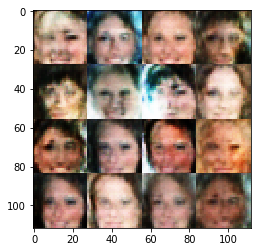

Epoch 1/1 ---  Discriminator loss: 1.2672 Generator loss: 1.0951
Epoch 1/1 ---  Discriminator loss: 1.5112 Generator loss: 0.4452
Epoch 1/1 ---  Discriminator loss: 1.2269 Generator loss: 0.7304
Epoch 1/1 ---  Discriminator loss: 1.5918 Generator loss: 1.3363
Epoch 1/1 ---  Discriminator loss: 1.2756 Generator loss: 0.6388
Epoch 1/1 ---  Discriminator loss: 1.3614 Generator loss: 0.6595
Epoch 1/1 ---  Discriminator loss: 1.2025 Generator loss: 0.5660
Epoch 1/1 ---  Discriminator loss: 1.3819 Generator loss: 0.9725
Epoch 1/1 ---  Discriminator loss: 1.2321 Generator loss: 0.7571
Epoch 1/1 ---  Discriminator loss: 1.3334 Generator loss: 0.7835


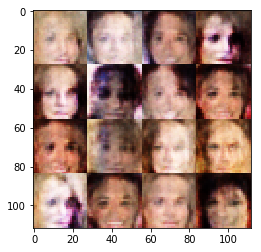

Epoch 1/1 ---  Discriminator loss: 1.4519 Generator loss: 0.9522
Epoch 1/1 ---  Discriminator loss: 1.1618 Generator loss: 0.7377
Epoch 1/1 ---  Discriminator loss: 1.2241 Generator loss: 0.5590
Epoch 1/1 ---  Discriminator loss: 1.2792 Generator loss: 0.5638
Epoch 1/1 ---  Discriminator loss: 1.5021 Generator loss: 0.4302
Epoch 1/1 ---  Discriminator loss: 1.1843 Generator loss: 1.0138
Epoch 1/1 ---  Discriminator loss: 1.3610 Generator loss: 0.4787
Epoch 1/1 ---  Discriminator loss: 1.3322 Generator loss: 0.5119
Epoch 1/1 ---  Discriminator loss: 1.2539 Generator loss: 0.6496
Epoch 1/1 ---  Discriminator loss: 1.4060 Generator loss: 0.5486


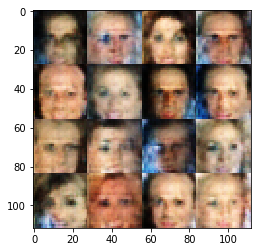

Epoch 1/1 ---  Discriminator loss: 1.3123 Generator loss: 1.0591
Epoch 1/1 ---  Discriminator loss: 1.1842 Generator loss: 0.9404
Epoch 1/1 ---  Discriminator loss: 1.2831 Generator loss: 0.6100
Epoch 1/1 ---  Discriminator loss: 1.3410 Generator loss: 0.6521
Epoch 1/1 ---  Discriminator loss: 1.4007 Generator loss: 1.0145
Epoch 1/1 ---  Discriminator loss: 1.1682 Generator loss: 0.6931
Epoch 1/1 ---  Discriminator loss: 1.2701 Generator loss: 0.8540
Epoch 1/1 ---  Discriminator loss: 1.1700 Generator loss: 1.1500
Epoch 1/1 ---  Discriminator loss: 1.3637 Generator loss: 0.6656
Epoch 1/1 ---  Discriminator loss: 1.2310 Generator loss: 0.7743


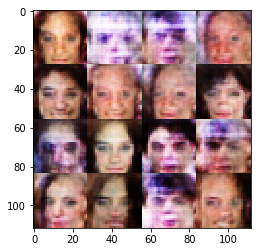

Epoch 1/1 ---  Discriminator loss: 1.4509 Generator loss: 0.5062
Epoch 1/1 ---  Discriminator loss: 1.2962 Generator loss: 0.6757
Epoch 1/1 ---  Discriminator loss: 1.8512 Generator loss: 0.2241
Epoch 1/1 ---  Discriminator loss: 1.1883 Generator loss: 0.7683
Epoch 1/1 ---  Discriminator loss: 1.5976 Generator loss: 0.3363
Epoch 1/1 ---  Discriminator loss: 1.4888 Generator loss: 0.5392
Epoch 1/1 ---  Discriminator loss: 1.1805 Generator loss: 0.8818
Epoch 1/1 ---  Discriminator loss: 1.4409 Generator loss: 0.4337
Epoch 1/1 ---  Discriminator loss: 1.4034 Generator loss: 0.5412
Epoch 1/1 ---  Discriminator loss: 1.3218 Generator loss: 0.6232


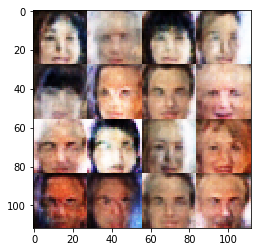

Epoch 1/1 ---  Discriminator loss: 1.3355 Generator loss: 0.6863
Epoch 1/1 ---  Discriminator loss: 1.3751 Generator loss: 0.6022
Epoch 1/1 ---  Discriminator loss: 1.2528 Generator loss: 0.6724
Epoch 1/1 ---  Discriminator loss: 1.2253 Generator loss: 0.7258
Epoch 1/1 ---  Discriminator loss: 1.2701 Generator loss: 0.9040
Epoch 1/1 ---  Discriminator loss: 1.2823 Generator loss: 0.8893
Epoch 1/1 ---  Discriminator loss: 1.2197 Generator loss: 0.6685
Epoch 1/1 ---  Discriminator loss: 1.1585 Generator loss: 0.9165
Epoch 1/1 ---  Discriminator loss: 1.4241 Generator loss: 0.4069
Epoch 1/1 ---  Discriminator loss: 1.1031 Generator loss: 0.8717


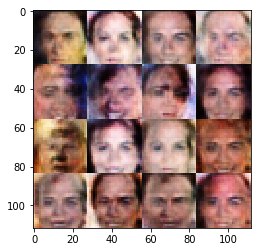

Epoch 1/1 ---  Discriminator loss: 1.2934 Generator loss: 1.1353
Epoch 1/1 ---  Discriminator loss: 1.3131 Generator loss: 0.5001
Epoch 1/1 ---  Discriminator loss: 1.2664 Generator loss: 0.7487
Epoch 1/1 ---  Discriminator loss: 1.3026 Generator loss: 0.4999
Epoch 1/1 ---  Discriminator loss: 1.3078 Generator loss: 0.9046
Epoch 1/1 ---  Discriminator loss: 1.2402 Generator loss: 0.6049
Epoch 1/1 ---  Discriminator loss: 1.3901 Generator loss: 0.4606
Epoch 1/1 ---  Discriminator loss: 1.3469 Generator loss: 0.7802
Epoch 1/1 ---  Discriminator loss: 1.3526 Generator loss: 0.6895
Epoch 1/1 ---  Discriminator loss: 1.0201 Generator loss: 1.0763


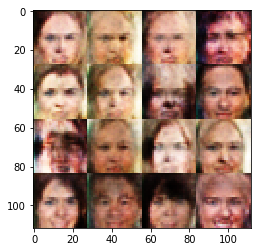

Epoch 1/1 ---  Discriminator loss: 1.1290 Generator loss: 0.6971
Epoch 1/1 ---  Discriminator loss: 1.2846 Generator loss: 0.6136
Epoch 1/1 ---  Discriminator loss: 1.3065 Generator loss: 1.2472
Epoch 1/1 ---  Discriminator loss: 1.1957 Generator loss: 0.8429
Epoch 1/1 ---  Discriminator loss: 1.2896 Generator loss: 0.9779
Epoch 1/1 ---  Discriminator loss: 1.3176 Generator loss: 0.5684
Epoch 1/1 ---  Discriminator loss: 1.3435 Generator loss: 0.4354
Epoch 1/1 ---  Discriminator loss: 1.1969 Generator loss: 0.7649
Epoch 1/1 ---  Discriminator loss: 1.4156 Generator loss: 1.3053
Epoch 1/1 ---  Discriminator loss: 1.3073 Generator loss: 0.6638


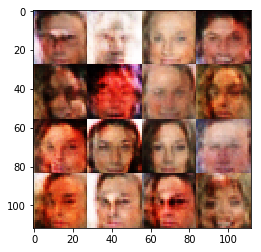

Epoch 1/1 ---  Discriminator loss: 1.4311 Generator loss: 0.6244
Epoch 1/1 ---  Discriminator loss: 1.3141 Generator loss: 0.6043
Epoch 1/1 ---  Discriminator loss: 1.2938 Generator loss: 0.6792
Epoch 1/1 ---  Discriminator loss: 1.2628 Generator loss: 0.7711
Epoch 1/1 ---  Discriminator loss: 1.4205 Generator loss: 0.6390
Epoch 1/1 ---  Discriminator loss: 1.3876 Generator loss: 0.8172
Epoch 1/1 ---  Discriminator loss: 1.1626 Generator loss: 0.8754
Epoch 1/1 ---  Discriminator loss: 1.2157 Generator loss: 0.5852
Epoch 1/1 ---  Discriminator loss: 1.5343 Generator loss: 0.3214
Epoch 1/1 ---  Discriminator loss: 1.3157 Generator loss: 0.4621


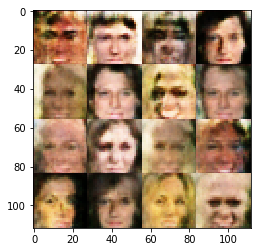

Epoch 1/1 ---  Discriminator loss: 1.5038 Generator loss: 0.4565
Epoch 1/1 ---  Discriminator loss: 1.4346 Generator loss: 0.4197
Epoch 1/1 ---  Discriminator loss: 1.2865 Generator loss: 0.7167
Epoch 1/1 ---  Discriminator loss: 1.3001 Generator loss: 0.5526
Epoch 1/1 ---  Discriminator loss: 1.0839 Generator loss: 1.0442
Epoch 1/1 ---  Discriminator loss: 1.2506 Generator loss: 1.0215
Epoch 1/1 ---  Discriminator loss: 1.2702 Generator loss: 0.6301
Epoch 1/1 ---  Discriminator loss: 1.3460 Generator loss: 0.5642
Epoch 1/1 ---  Discriminator loss: 1.2695 Generator loss: 0.6975
Epoch 1/1 ---  Discriminator loss: 1.2503 Generator loss: 0.6991


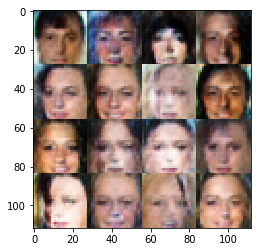

Epoch 1/1 ---  Discriminator loss: 1.2628 Generator loss: 1.2027
Epoch 1/1 ---  Discriminator loss: 1.2636 Generator loss: 0.4806
Epoch 1/1 ---  Discriminator loss: 1.2636 Generator loss: 0.9461
Epoch 1/1 ---  Discriminator loss: 1.2592 Generator loss: 0.8210
Epoch 1/1 ---  Discriminator loss: 1.1242 Generator loss: 0.9012
Epoch 1/1 ---  Discriminator loss: 1.2522 Generator loss: 0.6451
Epoch 1/1 ---  Discriminator loss: 1.2430 Generator loss: 0.6743
Epoch 1/1 ---  Discriminator loss: 1.5349 Generator loss: 0.3956
Epoch 1/1 ---  Discriminator loss: 1.2276 Generator loss: 0.6253
Epoch 1/1 ---  Discriminator loss: 1.3160 Generator loss: 0.4951


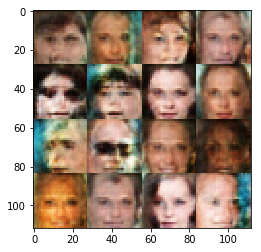

Epoch 1/1 ---  Discriminator loss: 1.1570 Generator loss: 0.9674
Epoch 1/1 ---  Discriminator loss: 1.4911 Generator loss: 0.6784
Epoch 1/1 ---  Discriminator loss: 1.2247 Generator loss: 1.1066
Epoch 1/1 ---  Discriminator loss: 1.3024 Generator loss: 0.7793
Epoch 1/1 ---  Discriminator loss: 1.3612 Generator loss: 1.2260
Epoch 1/1 ---  Discriminator loss: 1.3304 Generator loss: 0.4743
Epoch 1/1 ---  Discriminator loss: 1.3195 Generator loss: 1.0160
Epoch 1/1 ---  Discriminator loss: 1.1886 Generator loss: 0.6584
Epoch 1/1 ---  Discriminator loss: 1.4496 Generator loss: 0.4243
Epoch 1/1 ---  Discriminator loss: 1.1917 Generator loss: 0.6919


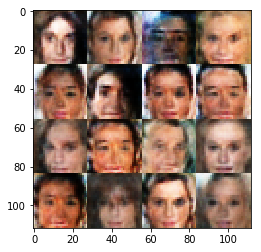

Epoch 1/1 ---  Discriminator loss: 1.2703 Generator loss: 0.8471
Epoch 1/1 ---  Discriminator loss: 1.3264 Generator loss: 0.5980
Epoch 1/1 ---  Discriminator loss: 1.3250 Generator loss: 0.8064
Epoch 1/1 ---  Discriminator loss: 1.4458 Generator loss: 0.4562
Epoch 1/1 ---  Discriminator loss: 1.1419 Generator loss: 1.0593
Epoch 1/1 ---  Discriminator loss: 1.3343 Generator loss: 0.9055
Epoch 1/1 ---  Discriminator loss: 1.3400 Generator loss: 0.4703
Epoch 1/1 ---  Discriminator loss: 1.4445 Generator loss: 0.4438
Epoch 1/1 ---  Discriminator loss: 1.2384 Generator loss: 0.8737
Epoch 1/1 ---  Discriminator loss: 1.1443 Generator loss: 0.9034


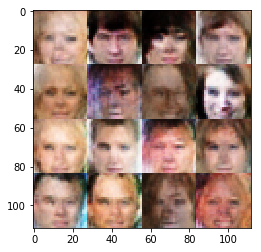

Epoch 1/1 ---  Discriminator loss: 1.3003 Generator loss: 0.6782
Epoch 1/1 ---  Discriminator loss: 1.2441 Generator loss: 0.5691
Epoch 1/1 ---  Discriminator loss: 1.2579 Generator loss: 0.6903
Epoch 1/1 ---  Discriminator loss: 1.2473 Generator loss: 0.5769
Epoch 1/1 ---  Discriminator loss: 1.2686 Generator loss: 0.8083
Epoch 1/1 ---  Discriminator loss: 1.2619 Generator loss: 0.6683
Epoch 1/1 ---  Discriminator loss: 1.3205 Generator loss: 0.5120
Epoch 1/1 ---  Discriminator loss: 1.0805 Generator loss: 1.0694
Epoch 1/1 ---  Discriminator loss: 1.2133 Generator loss: 0.8919
Epoch 1/1 ---  Discriminator loss: 1.3961 Generator loss: 0.8793


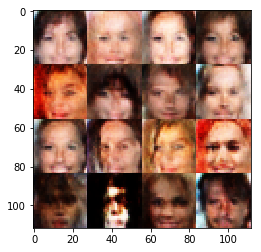

Epoch 1/1 ---  Discriminator loss: 1.3040 Generator loss: 0.8229
Epoch 1/1 ---  Discriminator loss: 1.4987 Generator loss: 0.4195
Epoch 1/1 ---  Discriminator loss: 1.1183 Generator loss: 0.8705
Epoch 1/1 ---  Discriminator loss: 1.5622 Generator loss: 0.3747
Epoch 1/1 ---  Discriminator loss: 1.2843 Generator loss: 0.7679
Epoch 1/1 ---  Discriminator loss: 1.2891 Generator loss: 0.5484
Epoch 1/1 ---  Discriminator loss: 1.0542 Generator loss: 1.0077
Epoch 1/1 ---  Discriminator loss: 1.2901 Generator loss: 1.0419
Epoch 1/1 ---  Discriminator loss: 1.1379 Generator loss: 0.7833
Epoch 1/1 ---  Discriminator loss: 1.1624 Generator loss: 1.5676


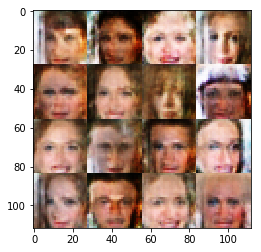

Epoch 1/1 ---  Discriminator loss: 1.3085 Generator loss: 0.8594
Epoch 1/1 ---  Discriminator loss: 1.4755 Generator loss: 0.3827
Epoch 1/1 ---  Discriminator loss: 1.2895 Generator loss: 0.6107
Epoch 1/1 ---  Discriminator loss: 1.3562 Generator loss: 0.7113
Epoch 1/1 ---  Discriminator loss: 1.3284 Generator loss: 0.6433
Epoch 1/1 ---  Discriminator loss: 1.3323 Generator loss: 0.4364
Epoch 1/1 ---  Discriminator loss: 1.4199 Generator loss: 0.4029
Epoch 1/1 ---  Discriminator loss: 1.2544 Generator loss: 0.6360
Epoch 1/1 ---  Discriminator loss: 1.1271 Generator loss: 1.1347
Epoch 1/1 ---  Discriminator loss: 1.4281 Generator loss: 0.6604


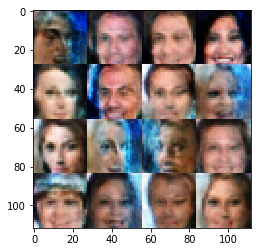

Epoch 1/1 ---  Discriminator loss: 1.3853 Generator loss: 0.7144
Epoch 1/1 ---  Discriminator loss: 1.1893 Generator loss: 0.7830
Epoch 1/1 ---  Discriminator loss: 1.2722 Generator loss: 0.5392
Epoch 1/1 ---  Discriminator loss: 1.3849 Generator loss: 0.8298
Epoch 1/1 ---  Discriminator loss: 1.1366 Generator loss: 0.7265
Epoch 1/1 ---  Discriminator loss: 1.3938 Generator loss: 0.6475
Epoch 1/1 ---  Discriminator loss: 1.3046 Generator loss: 0.5993
Epoch 1/1 ---  Discriminator loss: 1.2457 Generator loss: 0.6253
Epoch 1/1 ---  Discriminator loss: 1.2086 Generator loss: 0.7273
Epoch 1/1 ---  Discriminator loss: 1.4927 Generator loss: 0.3582


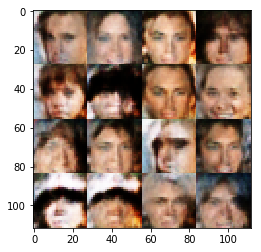

Epoch 1/1 ---  Discriminator loss: 1.5276 Generator loss: 0.4259
Epoch 1/1 ---  Discriminator loss: 1.1919 Generator loss: 0.7940
Epoch 1/1 ---  Discriminator loss: 1.2471 Generator loss: 0.5843
Epoch 1/1 ---  Discriminator loss: 1.3991 Generator loss: 0.6078
Epoch 1/1 ---  Discriminator loss: 1.1624 Generator loss: 0.8078
Epoch 1/1 ---  Discriminator loss: 1.3467 Generator loss: 0.8785
Epoch 1/1 ---  Discriminator loss: 1.3335 Generator loss: 0.5175
Epoch 1/1 ---  Discriminator loss: 1.2147 Generator loss: 0.8622
Epoch 1/1 ---  Discriminator loss: 1.2736 Generator loss: 0.8376
Epoch 1/1 ---  Discriminator loss: 1.3268 Generator loss: 0.8655


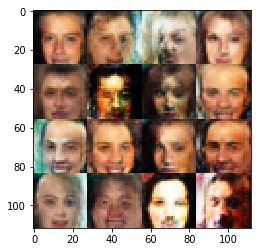

Epoch 1/1 ---  Discriminator loss: 1.1753 Generator loss: 0.6983
Epoch 1/1 ---  Discriminator loss: 1.4373 Generator loss: 0.5340
Epoch 1/1 ---  Discriminator loss: 1.3557 Generator loss: 0.6981
Epoch 1/1 ---  Discriminator loss: 1.2057 Generator loss: 0.7183
Epoch 1/1 ---  Discriminator loss: 1.2544 Generator loss: 0.6026
Epoch 1/1 ---  Discriminator loss: 1.1814 Generator loss: 0.7869
Epoch 1/1 ---  Discriminator loss: 1.2165 Generator loss: 0.9510
Epoch 1/1 ---  Discriminator loss: 1.3519 Generator loss: 0.4402
Epoch 1/1 ---  Discriminator loss: 1.3587 Generator loss: 0.4884
Epoch 1/1 ---  Discriminator loss: 1.2623 Generator loss: 0.6845


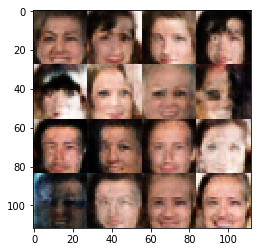

Epoch 1/1 ---  Discriminator loss: 1.2314 Generator loss: 0.7060
Epoch 1/1 ---  Discriminator loss: 1.1867 Generator loss: 0.7498
Epoch 1/1 ---  Discriminator loss: 1.3661 Generator loss: 0.4412
Epoch 1/1 ---  Discriminator loss: 1.5486 Generator loss: 0.6364
Epoch 1/1 ---  Discriminator loss: 1.3280 Generator loss: 0.5073
Epoch 1/1 ---  Discriminator loss: 1.1057 Generator loss: 0.9088
Epoch 1/1 ---  Discriminator loss: 1.2925 Generator loss: 0.7920
Epoch 1/1 ---  Discriminator loss: 1.2067 Generator loss: 0.7014
Epoch 1/1 ---  Discriminator loss: 1.0775 Generator loss: 0.6799
Epoch 1/1 ---  Discriminator loss: 1.2098 Generator loss: 0.8852


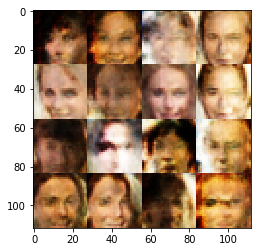

Epoch 1/1 ---  Discriminator loss: 1.2649 Generator loss: 1.2233
Epoch 1/1 ---  Discriminator loss: 1.3639 Generator loss: 0.5737
Epoch 1/1 ---  Discriminator loss: 1.3331 Generator loss: 0.5505
Epoch 1/1 ---  Discriminator loss: 1.3015 Generator loss: 0.7843
Epoch 1/1 ---  Discriminator loss: 1.2485 Generator loss: 0.6427
Epoch 1/1 ---  Discriminator loss: 1.3280 Generator loss: 0.5506
Epoch 1/1 ---  Discriminator loss: 1.3191 Generator loss: 0.7718
Epoch 1/1 ---  Discriminator loss: 1.2604 Generator loss: 0.5297
Epoch 1/1 ---  Discriminator loss: 1.2823 Generator loss: 0.9097
Epoch 1/1 ---  Discriminator loss: 1.3883 Generator loss: 0.5480


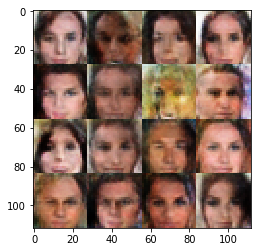

Epoch 1/1 ---  Discriminator loss: 1.5304 Generator loss: 0.3854
Epoch 1/1 ---  Discriminator loss: 1.5378 Generator loss: 0.3848
Epoch 1/1 ---  Discriminator loss: 1.3509 Generator loss: 0.5029
Epoch 1/1 ---  Discriminator loss: 1.0947 Generator loss: 0.7453
Epoch 1/1 ---  Discriminator loss: 1.2374 Generator loss: 0.6686
Epoch 1/1 ---  Discriminator loss: 1.3599 Generator loss: 0.4503
Epoch 1/1 ---  Discriminator loss: 1.4033 Generator loss: 0.7168
Epoch 1/1 ---  Discriminator loss: 1.3493 Generator loss: 1.0574
Epoch 1/1 ---  Discriminator loss: 1.2465 Generator loss: 0.7106
Epoch 1/1 ---  Discriminator loss: 1.1681 Generator loss: 0.8565


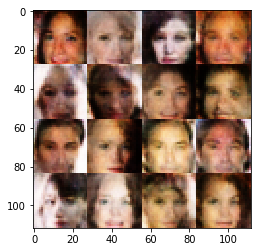

Epoch 1/1 ---  Discriminator loss: 1.4648 Generator loss: 0.3735
Epoch 1/1 ---  Discriminator loss: 1.2708 Generator loss: 0.6527
Epoch 1/1 ---  Discriminator loss: 1.3407 Generator loss: 0.6411
Epoch 1/1 ---  Discriminator loss: 1.4409 Generator loss: 0.5316
Epoch 1/1 ---  Discriminator loss: 1.4885 Generator loss: 0.4623
Epoch 1/1 ---  Discriminator loss: 1.1445 Generator loss: 0.9066
Epoch 1/1 ---  Discriminator loss: 1.4346 Generator loss: 0.4849
Epoch 1/1 ---  Discriminator loss: 1.3083 Generator loss: 0.6203
Epoch 1/1 ---  Discriminator loss: 1.3443 Generator loss: 0.5206
Epoch 1/1 ---  Discriminator loss: 1.2245 Generator loss: 0.5713


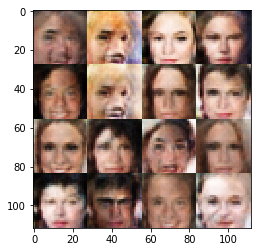

Epoch 1/1 ---  Discriminator loss: 1.3123 Generator loss: 0.6559
Epoch 1/1 ---  Discriminator loss: 1.1558 Generator loss: 0.7012
Epoch 1/1 ---  Discriminator loss: 1.3809 Generator loss: 0.4704
Epoch 1/1 ---  Discriminator loss: 1.1526 Generator loss: 0.6493
Epoch 1/1 ---  Discriminator loss: 1.2724 Generator loss: 0.9347
Epoch 1/1 ---  Discriminator loss: 1.3103 Generator loss: 0.6025
Epoch 1/1 ---  Discriminator loss: 1.3369 Generator loss: 0.9465
Epoch 1/1 ---  Discriminator loss: 1.3116 Generator loss: 0.8808
Epoch 1/1 ---  Discriminator loss: 1.1542 Generator loss: 0.6551
Epoch 1/1 ---  Discriminator loss: 1.4308 Generator loss: 0.9276


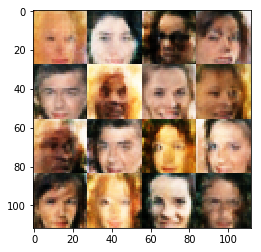

Epoch 1/1 ---  Discriminator loss: 1.2555 Generator loss: 0.5653
Epoch 1/1 ---  Discriminator loss: 1.1775 Generator loss: 0.6762
Epoch 1/1 ---  Discriminator loss: 1.2335 Generator loss: 0.6278
Epoch 1/1 ---  Discriminator loss: 1.4291 Generator loss: 0.4333
Epoch 1/1 ---  Discriminator loss: 1.2652 Generator loss: 0.9613
Epoch 1/1 ---  Discriminator loss: 1.2662 Generator loss: 0.5381
Epoch 1/1 ---  Discriminator loss: 1.4460 Generator loss: 0.4139
Epoch 1/1 ---  Discriminator loss: 1.2932 Generator loss: 0.6113
Epoch 1/1 ---  Discriminator loss: 1.3328 Generator loss: 0.5637
Epoch 1/1 ---  Discriminator loss: 1.4247 Generator loss: 0.5126


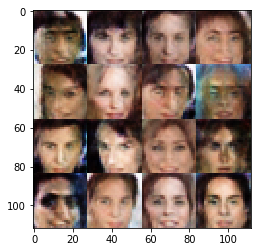

Epoch 1/1 ---  Discriminator loss: 1.3069 Generator loss: 0.5558
Epoch 1/1 ---  Discriminator loss: 1.2382 Generator loss: 0.6468
Epoch 1/1 ---  Discriminator loss: 1.2304 Generator loss: 0.5357
Epoch 1/1 ---  Discriminator loss: 1.1195 Generator loss: 0.8473
Epoch 1/1 ---  Discriminator loss: 1.2067 Generator loss: 0.8376
Epoch 1/1 ---  Discriminator loss: 1.2094 Generator loss: 0.6247
Epoch 1/1 ---  Discriminator loss: 1.2084 Generator loss: 0.7205
Epoch 1/1 ---  Discriminator loss: 1.2964 Generator loss: 0.8712
Epoch 1/1 ---  Discriminator loss: 1.1903 Generator loss: 0.7534
Epoch 1/1 ---  Discriminator loss: 1.2133 Generator loss: 0.6414


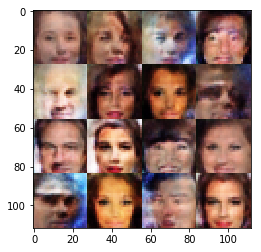

Epoch 1/1 ---  Discriminator loss: 1.1833 Generator loss: 0.7544
Epoch 1/1 ---  Discriminator loss: 1.1261 Generator loss: 1.1336
Epoch 1/1 ---  Discriminator loss: 1.5550 Generator loss: 0.3501
Epoch 1/1 ---  Discriminator loss: 1.2523 Generator loss: 0.6605
Epoch 1/1 ---  Discriminator loss: 1.2904 Generator loss: 0.6289
Epoch 1/1 ---  Discriminator loss: 1.4277 Generator loss: 0.4213
Epoch 1/1 ---  Discriminator loss: 1.2454 Generator loss: 0.5919
Epoch 1/1 ---  Discriminator loss: 1.1842 Generator loss: 0.9133
Epoch 1/1 ---  Discriminator loss: 1.2989 Generator loss: 0.7323
Epoch 1/1 ---  Discriminator loss: 1.3975 Generator loss: 0.8376


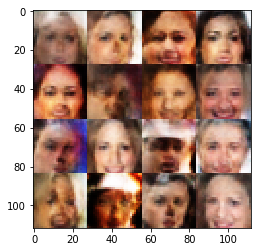

Epoch 1/1 ---  Discriminator loss: 1.4498 Generator loss: 0.4317
Epoch 1/1 ---  Discriminator loss: 1.2795 Generator loss: 0.6692
Epoch 1/1 ---  Discriminator loss: 1.2487 Generator loss: 0.7369
Epoch 1/1 ---  Discriminator loss: 1.3394 Generator loss: 0.4836
Epoch 1/1 ---  Discriminator loss: 1.4148 Generator loss: 0.4261
Epoch 1/1 ---  Discriminator loss: 1.2467 Generator loss: 0.5984
Epoch 1/1 ---  Discriminator loss: 1.4219 Generator loss: 0.4523
Epoch 1/1 ---  Discriminator loss: 1.3550 Generator loss: 0.6186
Epoch 1/1 ---  Discriminator loss: 1.2701 Generator loss: 0.8536
Epoch 1/1 ---  Discriminator loss: 1.2061 Generator loss: 0.5922


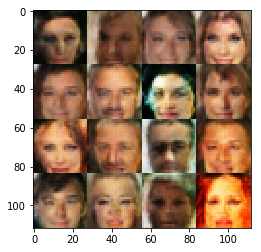

Epoch 1/1 ---  Discriminator loss: 1.2226 Generator loss: 0.5923
Epoch 1/1 ---  Discriminator loss: 1.1889 Generator loss: 0.5337
Epoch 1/1 ---  Discriminator loss: 1.3348 Generator loss: 0.5456
Epoch 1/1 ---  Discriminator loss: 1.2590 Generator loss: 0.6988
Epoch 1/1 ---  Discriminator loss: 1.2645 Generator loss: 0.7539
Epoch 1/1 ---  Discriminator loss: 1.2417 Generator loss: 1.1303
Epoch 1/1 ---  Discriminator loss: 1.1809 Generator loss: 0.7815
Epoch 1/1 ---  Discriminator loss: 1.2441 Generator loss: 0.5103
Epoch 1/1 ---  Discriminator loss: 1.3102 Generator loss: 0.5781
Epoch 1/1 ---  Discriminator loss: 1.0988 Generator loss: 1.0437


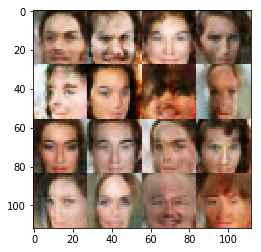

Epoch 1/1 ---  Discriminator loss: 1.5583 Generator loss: 0.3876
Epoch 1/1 ---  Discriminator loss: 1.3785 Generator loss: 0.7989
Epoch 1/1 ---  Discriminator loss: 1.2578 Generator loss: 0.8903
Epoch 1/1 ---  Discriminator loss: 1.1924 Generator loss: 0.8591
Epoch 1/1 ---  Discriminator loss: 1.2686 Generator loss: 0.7466
Epoch 1/1 ---  Discriminator loss: 1.3457 Generator loss: 0.7358
Epoch 1/1 ---  Discriminator loss: 1.2583 Generator loss: 0.8261
Epoch 1/1 ---  Discriminator loss: 1.3817 Generator loss: 0.4945
Epoch 1/1 ---  Discriminator loss: 1.3701 Generator loss: 0.4674
Epoch 1/1 ---  Discriminator loss: 1.3961 Generator loss: 0.8458


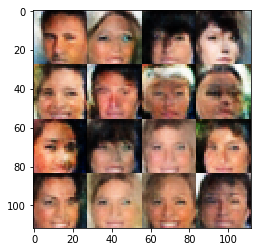

Epoch 1/1 ---  Discriminator loss: 1.2548 Generator loss: 0.5336
Epoch 1/1 ---  Discriminator loss: 1.3498 Generator loss: 0.4422
Epoch 1/1 ---  Discriminator loss: 1.2825 Generator loss: 0.6821
Epoch 1/1 ---  Discriminator loss: 1.3449 Generator loss: 0.5628
Epoch 1/1 ---  Discriminator loss: 1.2625 Generator loss: 0.6006
Epoch 1/1 ---  Discriminator loss: 1.3760 Generator loss: 0.6270
Epoch 1/1 ---  Discriminator loss: 1.4127 Generator loss: 0.5579
Epoch 1/1 ---  Discriminator loss: 1.3511 Generator loss: 0.8128
Epoch 1/1 ---  Discriminator loss: 1.2916 Generator loss: 0.7022
Epoch 1/1 ---  Discriminator loss: 1.2440 Generator loss: 0.6609


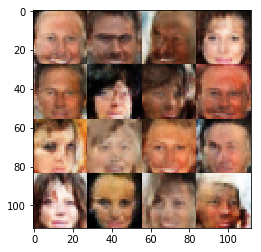

Epoch 1/1 ---  Discriminator loss: 1.2135 Generator loss: 0.6257
Epoch 1/1 ---  Discriminator loss: 1.2442 Generator loss: 0.7699
Epoch 1/1 ---  Discriminator loss: 1.2473 Generator loss: 0.5584
Epoch 1/1 ---  Discriminator loss: 1.2974 Generator loss: 0.9101
Epoch 1/1 ---  Discriminator loss: 1.2861 Generator loss: 0.7742
Epoch 1/1 ---  Discriminator loss: 1.3633 Generator loss: 0.4700
Epoch 1/1 ---  Discriminator loss: 1.2480 Generator loss: 0.6851
Epoch 1/1 ---  Discriminator loss: 1.2409 Generator loss: 0.8310
Epoch 1/1 ---  Discriminator loss: 1.5008 Generator loss: 1.0303
Epoch 1/1 ---  Discriminator loss: 1.3874 Generator loss: 0.9368


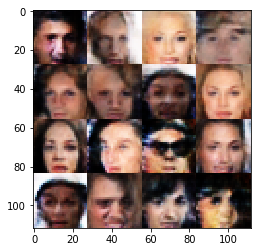

Epoch 1/1 ---  Discriminator loss: 1.2014 Generator loss: 0.6030
Epoch 1/1 ---  Discriminator loss: 1.3585 Generator loss: 0.6804
Epoch 1/1 ---  Discriminator loss: 1.2815 Generator loss: 1.0797
Epoch 1/1 ---  Discriminator loss: 1.2250 Generator loss: 0.6674
Epoch 1/1 ---  Discriminator loss: 1.2484 Generator loss: 0.5947
Epoch 1/1 ---  Discriminator loss: 1.1441 Generator loss: 0.6911
Epoch 1/1 ---  Discriminator loss: 1.4557 Generator loss: 0.7099
Epoch 1/1 ---  Discriminator loss: 1.2311 Generator loss: 0.7444
Epoch 1/1 ---  Discriminator loss: 1.2484 Generator loss: 0.5380
Epoch 1/1 ---  Discriminator loss: 1.2220 Generator loss: 0.5947


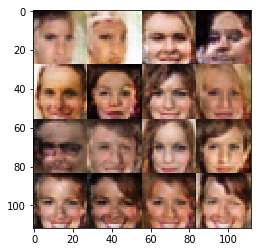

Epoch 1/1 ---  Discriminator loss: 1.1956 Generator loss: 0.5610
Epoch 1/1 ---  Discriminator loss: 1.3030 Generator loss: 0.6018
Epoch 1/1 ---  Discriminator loss: 1.1892 Generator loss: 0.7788
Epoch 1/1 ---  Discriminator loss: 1.3185 Generator loss: 0.5631
Epoch 1/1 ---  Discriminator loss: 1.1978 Generator loss: 0.8207
Epoch 1/1 ---  Discriminator loss: 1.3434 Generator loss: 0.5684
Epoch 1/1 ---  Discriminator loss: 1.4546 Generator loss: 0.4054
Epoch 1/1 ---  Discriminator loss: 1.3544 Generator loss: 0.5439
Epoch 1/1 ---  Discriminator loss: 1.4540 Generator loss: 0.8233
Epoch 1/1 ---  Discriminator loss: 1.3727 Generator loss: 0.4348


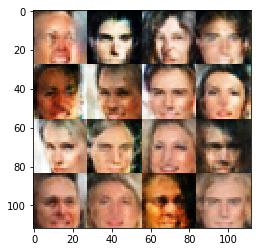

Epoch 1/1 ---  Discriminator loss: 1.1544 Generator loss: 0.8491
Epoch 1/1 ---  Discriminator loss: 1.2760 Generator loss: 0.6775
Epoch 1/1 ---  Discriminator loss: 1.2452 Generator loss: 0.7306
Epoch 1/1 ---  Discriminator loss: 1.2602 Generator loss: 0.5455
Epoch 1/1 ---  Discriminator loss: 1.5158 Generator loss: 0.9700
Epoch 1/1 ---  Discriminator loss: 1.4083 Generator loss: 0.5076
Epoch 1/1 ---  Discriminator loss: 1.2249 Generator loss: 0.6497
Epoch 1/1 ---  Discriminator loss: 1.3532 Generator loss: 1.0436
Epoch 1/1 ---  Discriminator loss: 1.2386 Generator loss: 0.6460
Epoch 1/1 ---  Discriminator loss: 1.3473 Generator loss: 0.7076


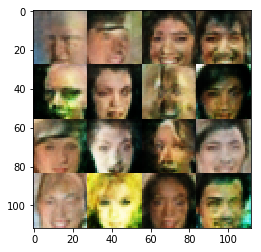

Epoch 1/1 ---  Discriminator loss: 1.1014 Generator loss: 0.7587
Epoch 1/1 ---  Discriminator loss: 1.3383 Generator loss: 0.5503
Epoch 1/1 ---  Discriminator loss: 1.2957 Generator loss: 1.0894
Epoch 1/1 ---  Discriminator loss: 1.1831 Generator loss: 0.5887
Epoch 1/1 ---  Discriminator loss: 1.3606 Generator loss: 1.1012
Epoch 1/1 ---  Discriminator loss: 1.3722 Generator loss: 0.5415
Epoch 1/1 ---  Discriminator loss: 1.2970 Generator loss: 0.5491
Epoch 1/1 ---  Discriminator loss: 1.2534 Generator loss: 0.6102
Epoch 1/1 ---  Discriminator loss: 1.2881 Generator loss: 0.7953
Epoch 1/1 ---  Discriminator loss: 1.2770 Generator loss: 0.5815


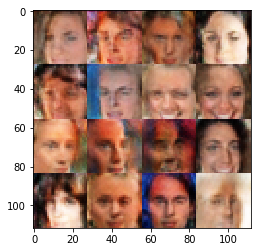

Epoch 1/1 ---  Discriminator loss: 1.2644 Generator loss: 0.7497
Epoch 1/1 ---  Discriminator loss: 1.3106 Generator loss: 0.6639
Epoch 1/1 ---  Discriminator loss: 1.3323 Generator loss: 0.7666
Epoch 1/1 ---  Discriminator loss: 1.2978 Generator loss: 0.7364
Epoch 1/1 ---  Discriminator loss: 1.3956 Generator loss: 0.8242
Epoch 1/1 ---  Discriminator loss: 1.4441 Generator loss: 0.3930
Epoch 1/1 ---  Discriminator loss: 1.1236 Generator loss: 0.9586
Epoch 1/1 ---  Discriminator loss: 1.2427 Generator loss: 0.6228
Epoch 1/1 ---  Discriminator loss: 1.3053 Generator loss: 0.5193
Epoch 1/1 ---  Discriminator loss: 1.1982 Generator loss: 0.7565


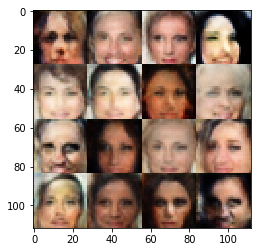

Epoch 1/1 ---  Discriminator loss: 1.2714 Generator loss: 0.6855
Epoch 1/1 ---  Discriminator loss: 1.2842 Generator loss: 0.7572
Epoch 1/1 ---  Discriminator loss: 1.2532 Generator loss: 0.8795
Epoch 1/1 ---  Discriminator loss: 1.2524 Generator loss: 0.6437
Epoch 1/1 ---  Discriminator loss: 1.5164 Generator loss: 0.3334
Epoch 1/1 ---  Discriminator loss: 1.4780 Generator loss: 0.6226
Epoch 1/1 ---  Discriminator loss: 1.3571 Generator loss: 0.6002
Epoch 1/1 ---  Discriminator loss: 1.2328 Generator loss: 0.5891
Epoch 1/1 ---  Discriminator loss: 1.2409 Generator loss: 0.6342
Epoch 1/1 ---  Discriminator loss: 1.4554 Generator loss: 0.3830


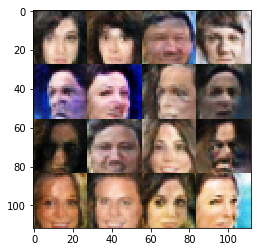

Epoch 1/1 ---  Discriminator loss: 1.2963 Generator loss: 0.5963
Epoch 1/1 ---  Discriminator loss: 1.2506 Generator loss: 1.1914
Epoch 1/1 ---  Discriminator loss: 1.2818 Generator loss: 0.6175
Epoch 1/1 ---  Discriminator loss: 1.5400 Generator loss: 1.0594
Epoch 1/1 ---  Discriminator loss: 1.1583 Generator loss: 0.8492
Epoch 1/1 ---  Discriminator loss: 1.2780 Generator loss: 0.7339
Epoch 1/1 ---  Discriminator loss: 1.1739 Generator loss: 0.7005
Epoch 1/1 ---  Discriminator loss: 1.2416 Generator loss: 0.5888
Epoch 1/1 ---  Discriminator loss: 1.2659 Generator loss: 0.6955
Epoch 1/1 ---  Discriminator loss: 1.3384 Generator loss: 0.7524


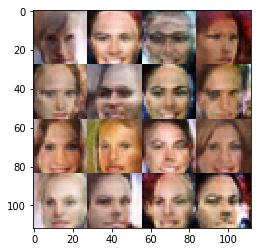

Epoch 1/1 ---  Discriminator loss: 1.2950 Generator loss: 0.7161
Epoch 1/1 ---  Discriminator loss: 1.3691 Generator loss: 0.6455
Epoch 1/1 ---  Discriminator loss: 1.2855 Generator loss: 0.5382
Epoch 1/1 ---  Discriminator loss: 1.2065 Generator loss: 0.7629
Epoch 1/1 ---  Discriminator loss: 1.2567 Generator loss: 0.6736
Epoch 1/1 ---  Discriminator loss: 1.2013 Generator loss: 0.6873
Epoch 1/1 ---  Discriminator loss: 1.4197 Generator loss: 0.4418
Epoch 1/1 ---  Discriminator loss: 1.3033 Generator loss: 0.5364
Epoch 1/1 ---  Discriminator loss: 1.3940 Generator loss: 0.4071
Epoch 1/1 ---  Discriminator loss: 1.4219 Generator loss: 0.4732


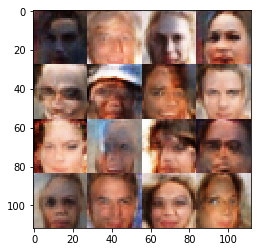

Epoch 1/1 ---  Discriminator loss: 1.0962 Generator loss: 0.8371
Epoch 1/1 ---  Discriminator loss: 1.3938 Generator loss: 0.9780
Epoch 1/1 ---  Discriminator loss: 1.2080 Generator loss: 0.6947
Epoch 1/1 ---  Discriminator loss: 1.3364 Generator loss: 0.5879
Epoch 1/1 ---  Discriminator loss: 1.3115 Generator loss: 0.5653
Epoch 1/1 ---  Discriminator loss: 1.4069 Generator loss: 0.6736
Epoch 1/1 ---  Discriminator loss: 1.2389 Generator loss: 0.6629
Epoch 1/1 ---  Discriminator loss: 1.4380 Generator loss: 0.9926
Epoch 1/1 ---  Discriminator loss: 1.2883 Generator loss: 0.7221
Epoch 1/1 ---  Discriminator loss: 1.1792 Generator loss: 0.8915


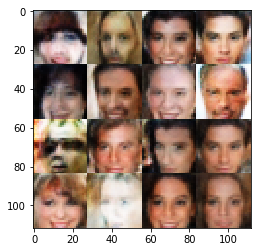

Epoch 1/1 ---  Discriminator loss: 1.4088 Generator loss: 0.5565
Epoch 1/1 ---  Discriminator loss: 1.3105 Generator loss: 0.5100
Epoch 1/1 ---  Discriminator loss: 1.2502 Generator loss: 0.5752
Epoch 1/1 ---  Discriminator loss: 1.2980 Generator loss: 0.5224
Epoch 1/1 ---  Discriminator loss: 1.4196 Generator loss: 0.4830
Epoch 1/1 ---  Discriminator loss: 1.2930 Generator loss: 0.6251
Epoch 1/1 ---  Discriminator loss: 1.4328 Generator loss: 0.4237
Epoch 1/1 ---  Discriminator loss: 1.2650 Generator loss: 0.7312
Epoch 1/1 ---  Discriminator loss: 1.2116 Generator loss: 0.8673
Epoch 1/1 ---  Discriminator loss: 1.2213 Generator loss: 0.7124


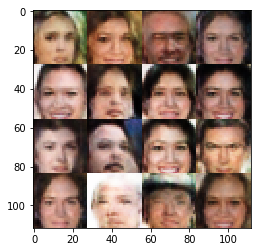

Epoch 1/1 ---  Discriminator loss: 1.5482 Generator loss: 0.3429
Epoch 1/1 ---  Discriminator loss: 1.2374 Generator loss: 0.6325
Epoch 1/1 ---  Discriminator loss: 1.3470 Generator loss: 0.5059
Epoch 1/1 ---  Discriminator loss: 1.4470 Generator loss: 0.5994
Epoch 1/1 ---  Discriminator loss: 1.2788 Generator loss: 0.6749
Epoch 1/1 ---  Discriminator loss: 1.1111 Generator loss: 0.7323
Epoch 1/1 ---  Discriminator loss: 1.5530 Generator loss: 0.9615
Epoch 1/1 ---  Discriminator loss: 1.0318 Generator loss: 0.9777
Epoch 1/1 ---  Discriminator loss: 1.1500 Generator loss: 0.7988
Epoch 1/1 ---  Discriminator loss: 1.4436 Generator loss: 0.4169


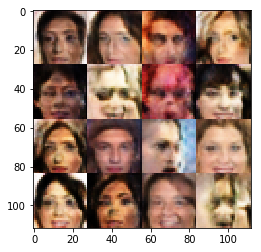

Epoch 1/1 ---  Discriminator loss: 1.3021 Generator loss: 0.7168
Epoch 1/1 ---  Discriminator loss: 1.4762 Generator loss: 0.4116
Epoch 1/1 ---  Discriminator loss: 1.3475 Generator loss: 0.5054


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.